## Google Drive Authentication

In [1]:
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/spreadsheets']


creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

try:
    service = build('drive', 'v3', credentials=creds)
    service_sheets = build('sheets', 'v4', credentials=creds)
    
    print("** Authentication Complete! **")

except HttpError as error:
    # TODO(developer) - Handle errors from drive API.
    print(f'An error occurred: {error}')


** Authentication Complete! **


## Google Drive API helper functions

In [2]:
import io
from googleapiclient.http import MediaIoBaseDownload
from os import listdir

def getFolderId(service, folderName: str):
    query = "name contains '%s' and mimeType = '%s'" % (folderName, 'application/vnd.google-apps.folder')

    fid = None

    if folderName.startswith('+'):
        return (folderName[1:])

    result = service.files().list(q=query,
                                  pageSize=10, pageToken='',
                                  fields="nextPageToken,files(parents,id,name,mimeType)").execute()
  
    if len(result['files']) == 0:
        print("Folder NOT found")
    else:
        folder = result.get('files')[0]
        fid = folder['id']

    return (fid)

    
def downloadFolder(service, fileId, destinationFolder):
    if not os.path.isdir(destinationFolder):
        os.mkdir(path=destinationFolder)

    results = service.files().list(
        pageSize=300,
        q="parents in '{0}'".format(fileId),
        fields="files(id, name, mimeType)"
        ).execute()

    items = results.get('files', [])

    for item in items:
        itemName = item['name']
        itemId = item['id']
        itemType = item['mimeType']
        filePath = destinationFolder + "/" + itemName

        if itemType == 'application/vnd.google-apps.folder':
            downloadFolder(service, itemId, filePath) # Recursive call
            print("Downloaded folder: {0}".format(itemName))
        elif not itemType.startswith('application/'):
            downloadFile(service, itemId, filePath)
        else:
            print("Unsupported file: {0}".format(itemName))


def downloadFile(service, fileId, filePath):
    # Note: The parent folders in filePath must exist
    request = service.files().get_media(fileId=fileId)
    fh = io.FileIO(filePath, mode='wb')
    
    try:
        downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)

        done = False
        while done is False:
            status, done = downloader.next_chunk(num_retries = 2)
    finally:
        fh.close()
        
def deleteFilesInFolder(folder_id):
    results = service.files().list(
        pageSize=300,
        q="parents in '{0}'".format(folder_id),
        fields="files(id, name, mimeType)"
        ).execute()

    items = results.get('files', [])
    for item in items:
        itemId = item['id']
        service.files().delete(fileId=itemId).execute()
        
def uploadFolder(service, folder_id, src_folder):        
    for file in listdir(src_folder):
        print('Uploading: ' + file)
        file_metadata = {'name': file, 'parents': [folder_id]}
        media = MediaFileUpload(os.path.join(src_folder, file), mimetype='image/png')
        file = service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

## Download Trait Files!

In [103]:
import shutil

traits_base_filepath = 'Traits'

# Delete previously downloaded trait files
if os.path.isdir(traits_base_filepath):
    shutil.rmtree(traits_base_filepath)

traits_folder_id = getFolderId(service, traits_base_filepath)

downloadFolder(service, traits_folder_id, traits_base_filepath)

print("\n** Download Complete! **")

Downloaded folder: parka
Downloaded folder: background
Downloaded folder: ears
Downloaded folder: blingpiece
Downloaded folder: bling
Downloaded folder: patch
Downloaded folder: satchels
Downloaded folder: quarter zip
Downloaded folder: glasses
Downloaded folder: upper + lower
Downloaded folder: short pants
Downloaded folder: hats + face
Downloaded folder: fur hat
Downloaded folder: ice cream
Downloaded folder: bowl cut
Downloaded folder: money
Downloaded folder: pillow
Downloaded folder: headphones
Downloaded folder: spilled carton
Downloaded folder: bucket hats
Downloaded folder: Flag Patches
Downloaded folder: Patches
Downloaded folder: beanies
Downloaded folder: Patches
Downloaded folder: baseball cap
Downloaded folder: hats
Downloaded folder: walkman
Downloaded folder: halo
Downloaded folder: dots
Downloaded folder: healthbar
Downloaded folder: external
Downloaded folder: beard
Downloaded folder: chinese mask
Downloaded folder: syringe
Downloaded folder: sticky notes
Downloaded fo

## Print all folders, files (BFS)

In [ ]:
folder_queue = [traits_base_filepath]

count = 0

#Generate rarity definitions
while folder_queue:
    curr_folder = folder_queue.pop(0)
    
    files = os.listdir(curr_folder)
    files = filter(lambda file: not file.startswith('.'), files)
    
    for file in files:
        print(file)
        if file.lower().endswith('.png'):
            count += 1
        if not file.lower().endswith('.png'):
            folder_queue.append(os.path.join(curr_folder, file))
            
print('\nPNG Count: ', count)

## Some more helper functions

In [3]:
from collections import deque
import random

# folder: subtrait
# traits_already_picked: keep track
# returns: chosen image(s), new set of already picked traits
def pick_trait_images(folder, traits_already_picked):
    
    png_files, folder_files = get_compatible_files(folder, traits_already_picked)

    if not png_files and not folder_files:
        return None, traits_already_picked
    
    chosen_image, chosen_folders = rarity_chooser(png_files, folder_files)
    chosen_folders = sort_on_list_order(chosen_folders, ["patch", "satchels", "bling"])
    
    traits_picked = []
    if chosen_image:
        traits_picked = get_traits_for_image(os.path.join(folder, chosen_image))
    
    # If only PNGs in folder
    if len(folder_files) == 0:
        return [os.path.join(folder, chosen_image)], traits_already_picked + traits_picked
    
    # If only folders in folder
    elif len(png_files) == 0:
        chosen_folder = chosen_folders[0]
        return pick_trait_images(os.path.join(folder, chosen_folder), traits_already_picked)
    
    # Both PNGs and folders in folder
    else:
        chosen_image_path = os.path.join(folder, chosen_image)
        picked_images_for_folders = []
        picked_traits_for_folders = []
        for chosen_folder in chosen_folders:
            picked_image, picked_traits = pick_trait_images(os.path.join(folder, chosen_folder), traits_already_picked + traits_picked)
            picked_images_for_folders.extend(picked_image)
            picked_traits_for_folders.extend(picked_traits)
        return [chosen_image_path] + picked_images_for_folders, traits_already_picked + traits_picked + picked_traits_for_folders
                                                        
# elems: list of PNGs/folders
def rarity_chooser(png_files, folder_files):
    
    if not png_files and not folder_files:
        return None, [None]
    
    elif not png_files and folder_files:
        return None, [weighted_pick(folder_files)]
    
    elif not folder_files and png_files:
        return weighted_pick(png_files), [None]
    
    else:
        chosen_png = weighted_pick(png_files)
        chosen_folders = []
        
        for file in folder_files:
            probability = rarity_dict[file]
            if probability and decision(probability):
                chosen_folders.append(file)
        
        return chosen_png, chosen_folders
    
def weighted_pick(files):
    weights = []
    for file in files:
        if not rarity_dict[file]:
            return random.choice(files)
        weights.append(int(rarity_dict[file]))
    
    choices = random.choices(files, weights=weights)
    return choices[0]
    
def decision(probability):
    return random.random() < float(probability)

# folder:
# traits_already_picked:
# returns: compatible files within folder that are compatible with traits_already_picked
def get_compatible_files(folder, traits_already_picked):
    files = os.listdir(folder)
    
    # Drop pesky ./DSStore files
    files = filter(lambda file: not file.startswith('.'), files)
    
    png_files = []
    folder_files = []
    for file in files:
        if file.lower().endswith('.png'):
            trait_name, color, _ = parse_png_filename(file)            
        
            if is_possible_choice(trait_name, exclusions_dict, traits_already_picked) & \
                is_possible_choice(color, exclusions_dict, traits_already_picked):
                png_files.append(file)
        else:
            if is_possible_choice(file, exclusions_dict, traits_already_picked):
                folder_files.append(file)
   

    return png_files, folder_files

def is_possible_choice(entry, exclusions_dict, traits_already_picked):
    return (entry not in exclusions_dict or not(set(exclusions_dict[entry]) & set(traits_already_picked)))

def get_traits_for_image(chosen_image):
    traits = chosen_image.split('/')
    trait_name, color, _ = parse_png_filename(traits[-1])
    traits[-1] = trait_name
    traits.append(color)
    return traits
    
def parse_png_filename(png_filename):
    png_filename = os.path.splitext(png_filename)[0]
    parsed_attributes = png_filename.split('_')
    if len(parsed_attributes) == 1:
        return parsed_attributes[0], "", ""
    elif len(parsed_attributes) == 2:
        return parsed_attributes[0], parsed_attributes[1], ""
    elif len(parsed_attributes) == 3:
        return parsed_attributes[0], parsed_attributes[1], parsed_attributes[2]
    
def get_last_index(inp_list, elem):
    index = None
    for idx, i in enumerate(inp_list):
        if i == elem:
            index = idx
    return index

def sort_on_list_order(unsorted_list, sorted_list):
    final_list = []
    for elem in sorted_list:
        if elem in unsorted_list:
            final_list.append(elem)
    
    unsorted_unfound_elems = list(set(unsorted_list) - set(final_list))
    final_list.extend(unsorted_unfound_elems)
    return final_list    

## Generate Babies!

In [4]:
from pathlib import Path

# Run this on update of either 1. layering order and 2. exclusions sheet

sheet = service_sheets.spreadsheets()

LAYERING_ORDER_SPREADSHEET_ID = '1aHC5g3mPSJGFAPF7UiQXDnV9BBUJCwnx8QHkMMip6uI'
LAYERING_ORDER_RANGE = 'A1:A'

EXCLUSIONS_SPREADSHEET_ID = '1S3Gbg24gwCmn_2AwThAIlRN9F0PEbA2v1Kn3QkaTjeY'
EXCLUSIONS_RANGE = 'A1:B'

RARITY_DEV_SPREADSHEET_ID = '1NhV9RmhDjme4MA4QMzMOTn9tdDoK-OL6kWK0XSG_G8M'
RARITY_SPREADSHEET_ID = '1rvtwtSps-1g35rhXMkt8zU1A7PV62FmFgwPDvZuTLL4'

BABIES_TO_IMAGES_SPREADSHEET_ID = '1AgRmweMAzKK7MdHsT9i5ZaRyr7fdhMp2h3zmpab2A6k'

RARITY_RANGE = 'A1:B'


result = sheet.values().get(spreadsheetId=LAYERING_ORDER_SPREADSHEET_ID, range=LAYERING_ORDER_RANGE).execute()
values = result.get('values', [])

ordered_traits = [item for sublist in values for item in sublist]

print("** Traits Ordering ingested! **\n")
    
## Generate warnings for trait exclusions
traits_dfs_order = []
folder_queue = ordered_traits[::-1]
folder_queue = ['Traits/' + path for path in folder_queue]

while folder_queue:
    curr_folder = folder_queue.pop(-1)
    traits_dfs_order.append(Path(curr_folder).stem)
    
    files = os.listdir(curr_folder)
    files = filter(lambda file: not file.startswith('.'), files)
    
    for file in files:
        if file.lower().endswith('.png'):
            trait, color, secondary_color = parse_png_filename(file)
            traits_dfs_order.append(trait)
            if color != "":
                traits_dfs_order.append(color)
            if secondary_color != "":
                traits_dfs_order.append(secondary_color)
        else:
             folder_queue.append(os.path.join(curr_folder, file))
            

result = sheet.values().get(spreadsheetId=EXCLUSIONS_SPREADSHEET_ID, range=EXCLUSIONS_RANGE).execute()
values = result.get('values', [])

# Warning generation
for val in values:
    if val[0] not in traits_dfs_order:
        print("\n** WARNING -- ", val[0], "in exclusions not a valid entry")
        break
    exclusions = val[1].split(',')
    for e in exclusions:
        if not get_last_index(traits_dfs_order, e):
            print("\n** WARNING -- ", e, "in exclusions is not a valid entry")
        else:
            if not get_last_index(traits_dfs_order, e) > traits_dfs_order.index(val[0]) and e != val[0]:
                print("\n** WARNING -- Ordering of ", val[0], ",", e, "in exclusions is not valid")

exclusions_dict = {}
for val in values:
    exclusions = val[1].split(',')
    for e in exclusions:
        if e not in exclusions_dict:
                exclusions_dict[e] = []
        exclusions_dict[e].append(val[0])

print("\n** Traits Exclusions ingested! **\n")    

# Rarity ingestion
result = sheet.values().get(spreadsheetId=RARITY_DEV_SPREADSHEET_ID, range=RARITY_RANGE).execute()
values = result.get('values', [])

rarity_dict = {}
for val in values:
    if len(val) == 1:
        rarity_dict[val[0]] = None
    elif len(val) == 2:
        rarity_dict[val[0]] = val[1]
    

print("\n Rarities Ingested!")

images_count = 10000

num_traits_excluding_body = 13

pagination_chunk = 50

babies_base_filepath = 'Babies'

traits_base_filepath = 'Traits'

** Traits Ordering ingested! **


** Traits Exclusions ingested! **


 Rarities Ingested!


In [187]:
from PIL import Image, ImageDraw, ImageChops
import shutil


# top level
def generate_baby_traits(ordered_traits, traits_base_filepath, babies_base_filepath):
    
    # BFS for trait images selection
    picked_trait_images = []
    picked_traits = []
    base_traits = ordered_traits
    
    # 1. Choose background
    background_trait_folder = base_traits.pop(0)
    curr_trait_dir = os.path.join(traits_base_filepath, background_trait_folder)
    picked_trait_image, picked_traits = pick_trait_images(curr_trait_dir, picked_traits)
    picked_trait_images.extend(picked_trait_image)

    # 2. choose the body trait
    body_trait_folder = base_traits.pop(0)
    curr_trait_dir = os.path.join(traits_base_filepath, body_trait_folder)
    picked_trait_image, picked_traits = pick_trait_images(curr_trait_dir, picked_traits)
    picked_trait_images.extend(picked_trait_image)
    
    # 3. Choose face traits
    face_traits = ['glasses', 'hats', 'face', 'hats + face', 'ears']
    picked_image = Path(picked_trait_image[0]).stem
    num_face_traits = 0
    chosen_face_traits = []
    if parse_png_filename(picked_image)[0] == 'bodyneutral':
        num_face_traits = random.randint(2, 3)
        for i in range(num_face_traits):
            _, [chosen_trait] = rarity_chooser([], face_traits)
            chosen_face_traits.append(chosen_trait)
    else:
        num_face_traits = random.randint(1, 3)
        for _ in range(num_face_traits):
            _, [chosen_trait] = rarity_chooser([], face_traits)
            chosen_face_traits.append(chosen_trait)
#     chosen_face_traits = sort_on_list_order(chosen_face_traits, face_traits)
#     chosen_face_traits = [face_traits[i] for i in sorted(random.sample(range(len(face_traits)), num_face_traits))]
    
    
    # 4. Randomly pick `num_traits_excluding_body` traits
    base_traits = list(set(base_traits) - set(face_traits))
    num_traits_excluding_body_face = num_traits_excluding_body - num_face_traits
    chosen_base_traits = []
    for _ in range(num_traits_excluding_body_face):
        _, [chosen_trait] = rarity_chooser([], base_traits)
        chosen_base_traits.append(chosen_trait)
#     chosen_base_traits = sort_on_list_order(chosen_base_traits, ordered_traits)
#     chosen_base_traits = [base_traits[i] for i in sorted(random.sample(range(len(base_traits)), num_traits_excluding_body_face))]
    
    unsorted_chosen_traits = chosen_base_traits + chosen_face_traits 
#     final_chosen_traits = [trait for x in ordered_traits for trait in unsorted_chosen_traits if trait == x]
    final_chosen_traits = sort_on_list_order(unsorted_chosen_traits, ordered_traits)
    
#     print("Chosen traits: " + str(final_chosen_traits))
    
    while final_chosen_traits:
        curr = final_chosen_traits.pop(0)
        if curr in exclusions_dict and (set(exclusions_dict[curr]) & set(picked_traits)):
            continue
            
        curr_trait_dir = os.path.join(traits_base_filepath, curr)
        
        # pick based on exclusions
        picked_trait_image, picked_traits = pick_trait_images(curr_trait_dir, picked_traits)
        if picked_trait_image: 
            picked_trait_images.extend(picked_trait_image)
    
    return picked_trait_images

def generate_baby_image(picked_trait_images):
    
    # Layer the images 
    x, y = Image.open(picked_trait_images[0]).size
    final_baby_image = Image.new('RGB', (x, y), (228, 150, 150))
    
    for trait_image in picked_trait_images:
        chosen_image = Image.open(trait_image)
        chosen_image = ImageChops.offset(chosen_image, 90, 0)
        final_baby_image.paste(chosen_image, (0, 0), chosen_image)
    
    # Crop to increase baby appearance
    final_baby_image = final_baby_image.crop((0, 140, final_baby_image.width - 140, final_baby_image.height))
    
    return final_baby_image, picked_trait_images

def upload_files_with_pagination():
    # Upload babies to drive
    babies_folder_id = getFolderId(service, babies_base_filepath)
    uploadFolder(service, babies_folder_id, os.path.join(babies_base_filepath))
        
    # Delete babies on file
    shutil.rmtree(babies_base_filepath)
    os.mkdir(babies_base_filepath)
    
def clear_babies_to_images_mapping_spreadsheet():
    body = {}
    resultClear = sheet.values().clear(spreadsheetId=BABIES_TO_IMAGES_SPREADSHEET_ID, range='A:B',
                                                       body=body).execute()

## Generate babies!

# Delete previously created baby files
if os.path.isdir(babies_base_filepath):
    shutil.rmtree(babies_base_filepath)
    
clear_babies_to_images_mapping_spreadsheet()

os.mkdir(babies_base_filepath)

for i in range(images_count):
    
    if i != 0 and i % pagination_chunk == 0:
        upload_files_with_pagination()
        
    picked_traits_images = generate_baby_traits(ordered_traits.copy(), traits_base_filepath, babies_base_filepath)
    final_baby_image, picked_images = generate_baby_image(picked_traits_images)
    
    # Write the image to file
    final_baby_image_file = '{:d}_lonely_baby.PNG'.format(i)
    final_baby_image.save(os.path.join(babies_base_filepath, final_baby_image_file))
    
    # Update babies to images mapping spreadsheet
    picked_images_str = ",".join(picked_images)
    values = [[final_baby_image_file, picked_images_str]]
    body = {
        'values': values
    }
    result = sheet.values().append(
        spreadsheetId=BABIES_TO_IMAGES_SPREADSHEET_ID, range='A:B',
        valueInputOption='RAW', body=body).execute()
    print('{0} cells appended.'.format(result
                                       .get('updates')
                                       .get('updatedCells')))
    
    print("Completed " + final_baby_image_file)

print("\n**Image generation complete! **")

2 cells appended.
Completed 0_lonely_baby.PNG
2 cells appended.
Completed 1_lonely_baby.PNG
2 cells appended.
Completed 2_lonely_baby.PNG
2 cells appended.
Completed 3_lonely_baby.PNG
2 cells appended.
Completed 4_lonely_baby.PNG
2 cells appended.
Completed 5_lonely_baby.PNG
2 cells appended.
Completed 6_lonely_baby.PNG
2 cells appended.
Completed 7_lonely_baby.PNG
2 cells appended.
Completed 8_lonely_baby.PNG
2 cells appended.
Completed 9_lonely_baby.PNG
2 cells appended.
Completed 10_lonely_baby.PNG
2 cells appended.
Completed 11_lonely_baby.PNG
2 cells appended.
Completed 12_lonely_baby.PNG
2 cells appended.
Completed 13_lonely_baby.PNG
2 cells appended.
Completed 14_lonely_baby.PNG
2 cells appended.
Completed 15_lonely_baby.PNG
2 cells appended.
Completed 16_lonely_baby.PNG
2 cells appended.
Completed 17_lonely_baby.PNG
2 cells appended.
Completed 18_lonely_baby.PNG
2 cells appended.
Completed 19_lonely_baby.PNG
2 cells appended.
Completed 20_lonely_baby.PNG
2 cells appended.
Compl

2 cells appended.
Completed 111_lonely_baby.PNG
2 cells appended.
Completed 112_lonely_baby.PNG
2 cells appended.
Completed 113_lonely_baby.PNG
2 cells appended.
Completed 114_lonely_baby.PNG
2 cells appended.
Completed 115_lonely_baby.PNG
2 cells appended.
Completed 116_lonely_baby.PNG
2 cells appended.
Completed 117_lonely_baby.PNG
2 cells appended.
Completed 118_lonely_baby.PNG
2 cells appended.
Completed 119_lonely_baby.PNG
2 cells appended.
Completed 120_lonely_baby.PNG
2 cells appended.
Completed 121_lonely_baby.PNG
2 cells appended.
Completed 122_lonely_baby.PNG
2 cells appended.
Completed 123_lonely_baby.PNG
2 cells appended.
Completed 124_lonely_baby.PNG
2 cells appended.
Completed 125_lonely_baby.PNG
2 cells appended.
Completed 126_lonely_baby.PNG
2 cells appended.
Completed 127_lonely_baby.PNG
2 cells appended.
Completed 128_lonely_baby.PNG
2 cells appended.
Completed 129_lonely_baby.PNG
2 cells appended.
Completed 130_lonely_baby.PNG
2 cells appended.
Completed 131_lonely_b

2 cells appended.
Completed 218_lonely_baby.PNG
2 cells appended.
Completed 219_lonely_baby.PNG
2 cells appended.
Completed 220_lonely_baby.PNG
2 cells appended.
Completed 221_lonely_baby.PNG
2 cells appended.
Completed 222_lonely_baby.PNG
2 cells appended.
Completed 223_lonely_baby.PNG
2 cells appended.
Completed 224_lonely_baby.PNG
2 cells appended.
Completed 225_lonely_baby.PNG
2 cells appended.
Completed 226_lonely_baby.PNG
2 cells appended.
Completed 227_lonely_baby.PNG
2 cells appended.
Completed 228_lonely_baby.PNG
2 cells appended.
Completed 229_lonely_baby.PNG
2 cells appended.
Completed 230_lonely_baby.PNG
2 cells appended.
Completed 231_lonely_baby.PNG
2 cells appended.
Completed 232_lonely_baby.PNG
2 cells appended.
Completed 233_lonely_baby.PNG
2 cells appended.
Completed 234_lonely_baby.PNG
2 cells appended.
Completed 235_lonely_baby.PNG
2 cells appended.
Completed 236_lonely_baby.PNG
2 cells appended.
Completed 237_lonely_baby.PNG
2 cells appended.
Completed 238_lonely_b

2 cells appended.
Completed 325_lonely_baby.PNG
2 cells appended.
Completed 326_lonely_baby.PNG
2 cells appended.
Completed 327_lonely_baby.PNG
2 cells appended.
Completed 328_lonely_baby.PNG
2 cells appended.
Completed 329_lonely_baby.PNG
2 cells appended.
Completed 330_lonely_baby.PNG
2 cells appended.
Completed 331_lonely_baby.PNG
2 cells appended.
Completed 332_lonely_baby.PNG
2 cells appended.
Completed 333_lonely_baby.PNG
2 cells appended.
Completed 334_lonely_baby.PNG
2 cells appended.
Completed 335_lonely_baby.PNG
2 cells appended.
Completed 336_lonely_baby.PNG
2 cells appended.
Completed 337_lonely_baby.PNG
2 cells appended.
Completed 338_lonely_baby.PNG
2 cells appended.
Completed 339_lonely_baby.PNG
2 cells appended.
Completed 340_lonely_baby.PNG
2 cells appended.
Completed 341_lonely_baby.PNG
2 cells appended.
Completed 342_lonely_baby.PNG
2 cells appended.
Completed 343_lonely_baby.PNG
2 cells appended.
Completed 344_lonely_baby.PNG
2 cells appended.
Completed 345_lonely_b

2 cells appended.
Completed 432_lonely_baby.PNG
2 cells appended.
Completed 433_lonely_baby.PNG
2 cells appended.
Completed 434_lonely_baby.PNG
2 cells appended.
Completed 435_lonely_baby.PNG
2 cells appended.
Completed 436_lonely_baby.PNG
2 cells appended.
Completed 437_lonely_baby.PNG
2 cells appended.
Completed 438_lonely_baby.PNG
2 cells appended.
Completed 439_lonely_baby.PNG
2 cells appended.
Completed 440_lonely_baby.PNG
2 cells appended.
Completed 441_lonely_baby.PNG
2 cells appended.
Completed 442_lonely_baby.PNG
2 cells appended.
Completed 443_lonely_baby.PNG
2 cells appended.
Completed 444_lonely_baby.PNG
2 cells appended.
Completed 445_lonely_baby.PNG
2 cells appended.
Completed 446_lonely_baby.PNG
2 cells appended.
Completed 447_lonely_baby.PNG
2 cells appended.
Completed 448_lonely_baby.PNG
2 cells appended.
Completed 449_lonely_baby.PNG
Uploading: 409_lonely_baby.PNG
Uploading: 434_lonely_baby.PNG
Uploading: 410_lonely_baby.PNG
Uploading: 422_lonely_baby.PNG
Uploading: 4

2 cells appended.
Completed 539_lonely_baby.PNG
2 cells appended.
Completed 540_lonely_baby.PNG
2 cells appended.
Completed 541_lonely_baby.PNG
2 cells appended.
Completed 542_lonely_baby.PNG
2 cells appended.
Completed 543_lonely_baby.PNG
2 cells appended.
Completed 544_lonely_baby.PNG
2 cells appended.
Completed 545_lonely_baby.PNG
2 cells appended.
Completed 546_lonely_baby.PNG
2 cells appended.
Completed 547_lonely_baby.PNG
2 cells appended.
Completed 548_lonely_baby.PNG
2 cells appended.
Completed 549_lonely_baby.PNG
Uploading: 546_lonely_baby.PNG
Uploading: 501_lonely_baby.PNG
Uploading: 518_lonely_baby.PNG
Uploading: 525_lonely_baby.PNG
Uploading: 517_lonely_baby.PNG
Uploading: 549_lonely_baby.PNG
Uploading: 533_lonely_baby.PNG
Uploading: 509_lonely_baby.PNG
Uploading: 534_lonely_baby.PNG
Uploading: 510_lonely_baby.PNG
Uploading: 522_lonely_baby.PNG
Uploading: 506_lonely_baby.PNG
Uploading: 541_lonely_baby.PNG
Uploading: 508_lonely_baby.PNG
Uploading: 535_lonely_baby.PNG
Uploadi

2 cells appended.
Completed 646_lonely_baby.PNG
2 cells appended.
Completed 647_lonely_baby.PNG
2 cells appended.
Completed 648_lonely_baby.PNG
2 cells appended.
Completed 649_lonely_baby.PNG
Uploading: 600_lonely_baby.PNG
Uploading: 647_lonely_baby.PNG
Uploading: 624_lonely_baby.PNG
Uploading: 619_lonely_baby.PNG
Uploading: 616_lonely_baby.PNG
Uploading: 632_lonely_baby.PNG
Uploading: 648_lonely_baby.PNG
Uploading: 635_lonely_baby.PNG
Uploading: 608_lonely_baby.PNG
Uploading: 611_lonely_baby.PNG
Uploading: 623_lonely_baby.PNG
Uploading: 640_lonely_baby.PNG
Uploading: 607_lonely_baby.PNG
Uploading: 634_lonely_baby.PNG
Uploading: 609_lonely_baby.PNG
Uploading: 610_lonely_baby.PNG
Uploading: 622_lonely_baby.PNG
Uploading: 606_lonely_baby.PNG
Uploading: 641_lonely_baby.PNG
Uploading: 646_lonely_baby.PNG
Uploading: 601_lonely_baby.PNG
Uploading: 625_lonely_baby.PNG
Uploading: 618_lonely_baby.PNG
Uploading: 617_lonely_baby.PNG
Uploading: 649_lonely_baby.PNG
Uploading: 633_lonely_baby.PNG
Up

Uploading: 740_lonely_baby.PNG
Uploading: 707_lonely_baby.PNG
Uploading: 700_lonely_baby.PNG
Uploading: 747_lonely_baby.PNG
Uploading: 724_lonely_baby.PNG
Uploading: 719_lonely_baby.PNG
Uploading: 716_lonely_baby.PNG
Uploading: 732_lonely_baby.PNG
Uploading: 748_lonely_baby.PNG
Uploading: 746_lonely_baby.PNG
Uploading: 701_lonely_baby.PNG
Uploading: 725_lonely_baby.PNG
Uploading: 718_lonely_baby.PNG
Uploading: 717_lonely_baby.PNG
Uploading: 749_lonely_baby.PNG
Uploading: 733_lonely_baby.PNG
Uploading: 734_lonely_baby.PNG
Uploading: 709_lonely_baby.PNG
Uploading: 710_lonely_baby.PNG
Uploading: 722_lonely_baby.PNG
Uploading: 706_lonely_baby.PNG
Uploading: 741_lonely_baby.PNG
Uploading: 727_lonely_baby.PNG
Uploading: 744_lonely_baby.PNG
Uploading: 703_lonely_baby.PNG
Uploading: 731_lonely_baby.PNG
Uploading: 728_lonely_baby.PNG
Uploading: 715_lonely_baby.PNG
Uploading: 712_lonely_baby.PNG
Uploading: 736_lonely_baby.PNG
Uploading: 739_lonely_baby.PNG
Uploading: 704_lonely_baby.PNG
Uploadin

Uploading: 838_lonely_baby.PNG
Uploading: 805_lonely_baby.PNG
Uploading: 842_lonely_baby.PNG
Uploading: 821_lonely_baby.PNG
Uploading: 826_lonely_baby.PNG
Uploading: 845_lonely_baby.PNG
Uploading: 802_lonely_baby.PNG
Uploading: 830_lonely_baby.PNG
Uploading: 829_lonely_baby.PNG
Uploading: 814_lonely_baby.PNG
Uploading: 835_lonely_baby.PNG
Uploading: 808_lonely_baby.PNG
Uploading: 811_lonely_baby.PNG
Uploading: 823_lonely_baby.PNG
Uploading: 807_lonely_baby.PNG
Uploading: 840_lonely_baby.PNG
Uploading: 847_lonely_baby.PNG
Uploading: 800_lonely_baby.PNG
Uploading: 824_lonely_baby.PNG
Uploading: 819_lonely_baby.PNG
Uploading: 816_lonely_baby.PNG
Uploading: 848_lonely_baby.PNG
Uploading: 832_lonely_baby.PNG
Uploading: 801_lonely_baby.PNG
Uploading: 846_lonely_baby.PNG
Uploading: 825_lonely_baby.PNG
Uploading: 818_lonely_baby.PNG
Uploading: 817_lonely_baby.PNG
Uploading: 833_lonely_baby.PNG
Uploading: 849_lonely_baby.PNG
Uploading: 834_lonely_baby.PNG
Uploading: 809_lonely_baby.PNG
Uploadin

Uploading: 947_lonely_baby.PNG
Uploading: 900_lonely_baby.PNG
Uploading: 924_lonely_baby.PNG
Uploading: 919_lonely_baby.PNG
Uploading: 916_lonely_baby.PNG
Uploading: 948_lonely_baby.PNG
Uploading: 932_lonely_baby.PNG
Uploading: 935_lonely_baby.PNG
Uploading: 908_lonely_baby.PNG
Uploading: 911_lonely_baby.PNG
Uploading: 923_lonely_baby.PNG
Uploading: 907_lonely_baby.PNG
Uploading: 940_lonely_baby.PNG
Uploading: 934_lonely_baby.PNG
Uploading: 909_lonely_baby.PNG
Uploading: 910_lonely_baby.PNG
Uploading: 922_lonely_baby.PNG
Uploading: 941_lonely_baby.PNG
Uploading: 906_lonely_baby.PNG
Uploading: 901_lonely_baby.PNG
Uploading: 946_lonely_baby.PNG
Uploading: 925_lonely_baby.PNG
Uploading: 918_lonely_baby.PNG
Uploading: 917_lonely_baby.PNG
Uploading: 933_lonely_baby.PNG
Uploading: 949_lonely_baby.PNG
2 cells appended.
Completed 950_lonely_baby.PNG
2 cells appended.
Completed 951_lonely_baby.PNG
2 cells appended.
Completed 952_lonely_baby.PNG
2 cells appended.
Completed 953_lonely_baby.PNG
2 

Uploading: 1011_lonely_baby.PNG
Uploading: 1035_lonely_baby.PNG
Uploading: 1008_lonely_baby.PNG
Uploading: 1040_lonely_baby.PNG
Uploading: 1007_lonely_baby.PNG
Uploading: 1023_lonely_baby.PNG
Uploading: 1010_lonely_baby.PNG
Uploading: 1034_lonely_baby.PNG
Uploading: 1009_lonely_baby.PNG
Uploading: 1006_lonely_baby.PNG
Uploading: 1041_lonely_baby.PNG
Uploading: 1022_lonely_baby.PNG
Uploading: 1025_lonely_baby.PNG
Uploading: 1018_lonely_baby.PNG
Uploading: 1046_lonely_baby.PNG
Uploading: 1001_lonely_baby.PNG
Uploading: 1049_lonely_baby.PNG
Uploading: 1033_lonely_baby.PNG
Uploading: 1017_lonely_baby.PNG
2 cells appended.
Completed 1050_lonely_baby.PNG
2 cells appended.
Completed 1051_lonely_baby.PNG
2 cells appended.
Completed 1052_lonely_baby.PNG
2 cells appended.
Completed 1053_lonely_baby.PNG
2 cells appended.
Completed 1054_lonely_baby.PNG
2 cells appended.
Completed 1055_lonely_baby.PNG
2 cells appended.
Completed 1056_lonely_baby.PNG
2 cells appended.
Completed 1057_lonely_baby.PNG


Uploading: 1132_lonely_baby.PNG
Uploading: 1148_lonely_baby.PNG
Uploading: 1116_lonely_baby.PNG
Uploading: 1125_lonely_baby.PNG
Uploading: 1118_lonely_baby.PNG
Uploading: 1146_lonely_baby.PNG
Uploading: 1101_lonely_baby.PNG
Uploading: 1149_lonely_baby.PNG
Uploading: 1133_lonely_baby.PNG
Uploading: 1117_lonely_baby.PNG
Uploading: 1110_lonely_baby.PNG
Uploading: 1134_lonely_baby.PNG
Uploading: 1109_lonely_baby.PNG
Uploading: 1106_lonely_baby.PNG
Uploading: 1141_lonely_baby.PNG
Uploading: 1122_lonely_baby.PNG
2 cells appended.
Completed 1150_lonely_baby.PNG
2 cells appended.
Completed 1151_lonely_baby.PNG
2 cells appended.
Completed 1152_lonely_baby.PNG
2 cells appended.
Completed 1153_lonely_baby.PNG
2 cells appended.
Completed 1154_lonely_baby.PNG
2 cells appended.
Completed 1155_lonely_baby.PNG
2 cells appended.
Completed 1156_lonely_baby.PNG
2 cells appended.
Completed 1157_lonely_baby.PNG
2 cells appended.
Completed 1158_lonely_baby.PNG
2 cells appended.
Completed 1159_lonely_baby.PN

Uploading: 1219_lonely_baby.PNG
Uploading: 1224_lonely_baby.PNG
Uploading: 1200_lonely_baby.PNG
Uploading: 1247_lonely_baby.PNG
Uploading: 1232_lonely_baby.PNG
Uploading: 1248_lonely_baby.PNG
Uploading: 1216_lonely_baby.PNG
Uploading: 1211_lonely_baby.PNG
Uploading: 1208_lonely_baby.PNG
Uploading: 1235_lonely_baby.PNG
Uploading: 1240_lonely_baby.PNG
Uploading: 1207_lonely_baby.PNG
Uploading: 1223_lonely_baby.PNG
2 cells appended.
Completed 1250_lonely_baby.PNG
2 cells appended.
Completed 1251_lonely_baby.PNG
2 cells appended.
Completed 1252_lonely_baby.PNG
2 cells appended.
Completed 1253_lonely_baby.PNG
2 cells appended.
Completed 1254_lonely_baby.PNG
2 cells appended.
Completed 1255_lonely_baby.PNG
2 cells appended.
Completed 1256_lonely_baby.PNG
2 cells appended.
Completed 1257_lonely_baby.PNG
2 cells appended.
Completed 1258_lonely_baby.PNG
2 cells appended.
Completed 1259_lonely_baby.PNG
2 cells appended.
Completed 1260_lonely_baby.PNG
2 cells appended.
Completed 1261_lonely_baby.

Uploading: 1340_lonely_baby.PNG
Uploading: 1307_lonely_baby.PNG
Uploading: 1323_lonely_baby.PNG
Uploading: 1319_lonely_baby.PNG
Uploading: 1324_lonely_baby.PNG
Uploading: 1300_lonely_baby.PNG
Uploading: 1347_lonely_baby.PNG
Uploading: 1332_lonely_baby.PNG
Uploading: 1348_lonely_baby.PNG
Uploading: 1316_lonely_baby.PNG
2 cells appended.
Completed 1350_lonely_baby.PNG
2 cells appended.
Completed 1351_lonely_baby.PNG
2 cells appended.
Completed 1352_lonely_baby.PNG
2 cells appended.
Completed 1353_lonely_baby.PNG
2 cells appended.
Completed 1354_lonely_baby.PNG
2 cells appended.
Completed 1355_lonely_baby.PNG
2 cells appended.
Completed 1356_lonely_baby.PNG
2 cells appended.
Completed 1357_lonely_baby.PNG
2 cells appended.
Completed 1358_lonely_baby.PNG
2 cells appended.
Completed 1359_lonely_baby.PNG
2 cells appended.
Completed 1360_lonely_baby.PNG
2 cells appended.
Completed 1361_lonely_baby.PNG
2 cells appended.
Completed 1362_lonely_baby.PNG
2 cells appended.
Completed 1363_lonely_bab

Uploading: 1401_lonely_baby.PNG
Uploading: 1406_lonely_baby.PNG
Uploading: 1441_lonely_baby.PNG
Uploading: 1422_lonely_baby.PNG
Uploading: 1410_lonely_baby.PNG
Uploading: 1434_lonely_baby.PNG
Uploading: 1409_lonely_baby.PNG
2 cells appended.
Completed 1450_lonely_baby.PNG
2 cells appended.
Completed 1451_lonely_baby.PNG
2 cells appended.
Completed 1452_lonely_baby.PNG
2 cells appended.
Completed 1453_lonely_baby.PNG
2 cells appended.
Completed 1454_lonely_baby.PNG
2 cells appended.
Completed 1455_lonely_baby.PNG
2 cells appended.
Completed 1456_lonely_baby.PNG
2 cells appended.
Completed 1457_lonely_baby.PNG
2 cells appended.
Completed 1458_lonely_baby.PNG
2 cells appended.
Completed 1459_lonely_baby.PNG
2 cells appended.
Completed 1460_lonely_baby.PNG
2 cells appended.
Completed 1461_lonely_baby.PNG
2 cells appended.
Completed 1462_lonely_baby.PNG
2 cells appended.
Completed 1463_lonely_baby.PNG
2 cells appended.
Completed 1464_lonely_baby.PNG
2 cells appended.
Completed 1465_lonely_b

Uploading: 1525_lonely_baby.PNG
Uploading: 1518_lonely_baby.PNG
Uploading: 1546_lonely_baby.PNG
Uploading: 1501_lonely_baby.PNG
2 cells appended.
Completed 1550_lonely_baby.PNG
2 cells appended.
Completed 1551_lonely_baby.PNG
2 cells appended.
Completed 1552_lonely_baby.PNG
2 cells appended.
Completed 1553_lonely_baby.PNG
2 cells appended.
Completed 1554_lonely_baby.PNG
2 cells appended.
Completed 1555_lonely_baby.PNG
2 cells appended.
Completed 1556_lonely_baby.PNG
2 cells appended.
Completed 1557_lonely_baby.PNG
2 cells appended.
Completed 1558_lonely_baby.PNG
2 cells appended.
Completed 1559_lonely_baby.PNG
2 cells appended.
Completed 1560_lonely_baby.PNG
2 cells appended.
Completed 1561_lonely_baby.PNG
2 cells appended.
Completed 1562_lonely_baby.PNG
2 cells appended.
Completed 1563_lonely_baby.PNG
2 cells appended.
Completed 1564_lonely_baby.PNG
2 cells appended.
Completed 1565_lonely_baby.PNG
2 cells appended.
Completed 1566_lonely_baby.PNG
2 cells appended.
Completed 1567_lonely

Uploading: 1647_lonely_baby.PNG
2 cells appended.
Completed 1650_lonely_baby.PNG
2 cells appended.
Completed 1651_lonely_baby.PNG
2 cells appended.
Completed 1652_lonely_baby.PNG
2 cells appended.
Completed 1653_lonely_baby.PNG
2 cells appended.
Completed 1654_lonely_baby.PNG
2 cells appended.
Completed 1655_lonely_baby.PNG
2 cells appended.
Completed 1656_lonely_baby.PNG
2 cells appended.
Completed 1657_lonely_baby.PNG
2 cells appended.
Completed 1658_lonely_baby.PNG
2 cells appended.
Completed 1659_lonely_baby.PNG
2 cells appended.
Completed 1660_lonely_baby.PNG
2 cells appended.
Completed 1661_lonely_baby.PNG
2 cells appended.
Completed 1662_lonely_baby.PNG
2 cells appended.
Completed 1663_lonely_baby.PNG
2 cells appended.
Completed 1664_lonely_baby.PNG
2 cells appended.
Completed 1665_lonely_baby.PNG
2 cells appended.
Completed 1666_lonely_baby.PNG
2 cells appended.
Completed 1667_lonely_baby.PNG
2 cells appended.
Completed 1668_lonely_baby.PNG
2 cells appended.
Completed 1669_lone

2 cells appended.
Completed 1752_lonely_baby.PNG
2 cells appended.
Completed 1753_lonely_baby.PNG
2 cells appended.
Completed 1754_lonely_baby.PNG
2 cells appended.
Completed 1755_lonely_baby.PNG
2 cells appended.
Completed 1756_lonely_baby.PNG
2 cells appended.
Completed 1757_lonely_baby.PNG
2 cells appended.
Completed 1758_lonely_baby.PNG
2 cells appended.
Completed 1759_lonely_baby.PNG
2 cells appended.
Completed 1760_lonely_baby.PNG
2 cells appended.
Completed 1761_lonely_baby.PNG
2 cells appended.
Completed 1762_lonely_baby.PNG
2 cells appended.
Completed 1763_lonely_baby.PNG
2 cells appended.
Completed 1764_lonely_baby.PNG
2 cells appended.
Completed 1765_lonely_baby.PNG
2 cells appended.
Completed 1766_lonely_baby.PNG
2 cells appended.
Completed 1767_lonely_baby.PNG
2 cells appended.
Completed 1768_lonely_baby.PNG
2 cells appended.
Completed 1769_lonely_baby.PNG
2 cells appended.
Completed 1770_lonely_baby.PNG
2 cells appended.
Completed 1771_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 1854_lonely_baby.PNG
2 cells appended.
Completed 1855_lonely_baby.PNG
2 cells appended.
Completed 1856_lonely_baby.PNG
2 cells appended.
Completed 1857_lonely_baby.PNG
2 cells appended.
Completed 1858_lonely_baby.PNG
2 cells appended.
Completed 1859_lonely_baby.PNG
2 cells appended.
Completed 1860_lonely_baby.PNG
2 cells appended.
Completed 1861_lonely_baby.PNG
2 cells appended.
Completed 1862_lonely_baby.PNG
2 cells appended.
Completed 1863_lonely_baby.PNG
2 cells appended.
Completed 1864_lonely_baby.PNG
2 cells appended.
Completed 1865_lonely_baby.PNG
2 cells appended.
Completed 1866_lonely_baby.PNG
2 cells appended.
Completed 1867_lonely_baby.PNG
2 cells appended.
Completed 1868_lonely_baby.PNG
2 cells appended.
Completed 1869_lonely_baby.PNG
2 cells appended.
Completed 1870_lonely_baby.PNG
2 cells appended.
Completed 1871_lonely_baby.PNG
2 cells appended.
Completed 1872_lonely_baby.PNG
2 cells appended.
Completed 1873_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 1956_lonely_baby.PNG
2 cells appended.
Completed 1957_lonely_baby.PNG
2 cells appended.
Completed 1958_lonely_baby.PNG
2 cells appended.
Completed 1959_lonely_baby.PNG
2 cells appended.
Completed 1960_lonely_baby.PNG
2 cells appended.
Completed 1961_lonely_baby.PNG
2 cells appended.
Completed 1962_lonely_baby.PNG
2 cells appended.
Completed 1963_lonely_baby.PNG
2 cells appended.
Completed 1964_lonely_baby.PNG
2 cells appended.
Completed 1965_lonely_baby.PNG
2 cells appended.
Completed 1966_lonely_baby.PNG
2 cells appended.
Completed 1967_lonely_baby.PNG
2 cells appended.
Completed 1968_lonely_baby.PNG
2 cells appended.
Completed 1969_lonely_baby.PNG
2 cells appended.
Completed 1970_lonely_baby.PNG
2 cells appended.
Completed 1971_lonely_baby.PNG
2 cells appended.
Completed 1972_lonely_baby.PNG
2 cells appended.
Completed 1973_lonely_baby.PNG
2 cells appended.
Completed 1974_lonely_baby.PNG
2 cells appended.
Completed 1975_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2058_lonely_baby.PNG
2 cells appended.
Completed 2059_lonely_baby.PNG
2 cells appended.
Completed 2060_lonely_baby.PNG
2 cells appended.
Completed 2061_lonely_baby.PNG
2 cells appended.
Completed 2062_lonely_baby.PNG
2 cells appended.
Completed 2063_lonely_baby.PNG
2 cells appended.
Completed 2064_lonely_baby.PNG
2 cells appended.
Completed 2065_lonely_baby.PNG
2 cells appended.
Completed 2066_lonely_baby.PNG
2 cells appended.
Completed 2067_lonely_baby.PNG
2 cells appended.
Completed 2068_lonely_baby.PNG
2 cells appended.
Completed 2069_lonely_baby.PNG
2 cells appended.
Completed 2070_lonely_baby.PNG
2 cells appended.
Completed 2071_lonely_baby.PNG
2 cells appended.
Completed 2072_lonely_baby.PNG
2 cells appended.
Completed 2073_lonely_baby.PNG
2 cells appended.
Completed 2074_lonely_baby.PNG
2 cells appended.
Completed 2075_lonely_baby.PNG
2 cells appended.
Completed 2076_lonely_baby.PNG
2 cells appended.
Completed 2077_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2160_lonely_baby.PNG
2 cells appended.
Completed 2161_lonely_baby.PNG
2 cells appended.
Completed 2162_lonely_baby.PNG
2 cells appended.
Completed 2163_lonely_baby.PNG
2 cells appended.
Completed 2164_lonely_baby.PNG
2 cells appended.
Completed 2165_lonely_baby.PNG
2 cells appended.
Completed 2166_lonely_baby.PNG
2 cells appended.
Completed 2167_lonely_baby.PNG
2 cells appended.
Completed 2168_lonely_baby.PNG
2 cells appended.
Completed 2169_lonely_baby.PNG
2 cells appended.
Completed 2170_lonely_baby.PNG
2 cells appended.
Completed 2171_lonely_baby.PNG
2 cells appended.
Completed 2172_lonely_baby.PNG
2 cells appended.
Completed 2173_lonely_baby.PNG
2 cells appended.
Completed 2174_lonely_baby.PNG
2 cells appended.
Completed 2175_lonely_baby.PNG
2 cells appended.
Completed 2176_lonely_baby.PNG
2 cells appended.
Completed 2177_lonely_baby.PNG
2 cells appended.
Completed 2178_lonely_baby.PNG
2 cells appended.
Completed 2179_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2262_lonely_baby.PNG
2 cells appended.
Completed 2263_lonely_baby.PNG
2 cells appended.
Completed 2264_lonely_baby.PNG
2 cells appended.
Completed 2265_lonely_baby.PNG
2 cells appended.
Completed 2266_lonely_baby.PNG
2 cells appended.
Completed 2267_lonely_baby.PNG
2 cells appended.
Completed 2268_lonely_baby.PNG
2 cells appended.
Completed 2269_lonely_baby.PNG
2 cells appended.
Completed 2270_lonely_baby.PNG
2 cells appended.
Completed 2271_lonely_baby.PNG
2 cells appended.
Completed 2272_lonely_baby.PNG
2 cells appended.
Completed 2273_lonely_baby.PNG
2 cells appended.
Completed 2274_lonely_baby.PNG
2 cells appended.
Completed 2275_lonely_baby.PNG
2 cells appended.
Completed 2276_lonely_baby.PNG
2 cells appended.
Completed 2277_lonely_baby.PNG
2 cells appended.
Completed 2278_lonely_baby.PNG
2 cells appended.
Completed 2279_lonely_baby.PNG
2 cells appended.
Completed 2280_lonely_baby.PNG
2 cells appended.
Completed 2281_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2364_lonely_baby.PNG
2 cells appended.
Completed 2365_lonely_baby.PNG
2 cells appended.
Completed 2366_lonely_baby.PNG
2 cells appended.
Completed 2367_lonely_baby.PNG
2 cells appended.
Completed 2368_lonely_baby.PNG
2 cells appended.
Completed 2369_lonely_baby.PNG
2 cells appended.
Completed 2370_lonely_baby.PNG
2 cells appended.
Completed 2371_lonely_baby.PNG
2 cells appended.
Completed 2372_lonely_baby.PNG
2 cells appended.
Completed 2373_lonely_baby.PNG
2 cells appended.
Completed 2374_lonely_baby.PNG
2 cells appended.
Completed 2375_lonely_baby.PNG
2 cells appended.
Completed 2376_lonely_baby.PNG
2 cells appended.
Completed 2377_lonely_baby.PNG
2 cells appended.
Completed 2378_lonely_baby.PNG
2 cells appended.
Completed 2379_lonely_baby.PNG
2 cells appended.
Completed 2380_lonely_baby.PNG
2 cells appended.
Completed 2381_lonely_baby.PNG
2 cells appended.
Completed 2382_lonely_baby.PNG
2 cells appended.
Completed 2383_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2466_lonely_baby.PNG
2 cells appended.
Completed 2467_lonely_baby.PNG
2 cells appended.
Completed 2468_lonely_baby.PNG
2 cells appended.
Completed 2469_lonely_baby.PNG
2 cells appended.
Completed 2470_lonely_baby.PNG
2 cells appended.
Completed 2471_lonely_baby.PNG
2 cells appended.
Completed 2472_lonely_baby.PNG
2 cells appended.
Completed 2473_lonely_baby.PNG
2 cells appended.
Completed 2474_lonely_baby.PNG
2 cells appended.
Completed 2475_lonely_baby.PNG
2 cells appended.
Completed 2476_lonely_baby.PNG
2 cells appended.
Completed 2477_lonely_baby.PNG
2 cells appended.
Completed 2478_lonely_baby.PNG
2 cells appended.
Completed 2479_lonely_baby.PNG
2 cells appended.
Completed 2480_lonely_baby.PNG
2 cells appended.
Completed 2481_lonely_baby.PNG
2 cells appended.
Completed 2482_lonely_baby.PNG
2 cells appended.
Completed 2483_lonely_baby.PNG
2 cells appended.
Completed 2484_lonely_baby.PNG
2 cells appended.
Completed 2485_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2568_lonely_baby.PNG
2 cells appended.
Completed 2569_lonely_baby.PNG
2 cells appended.
Completed 2570_lonely_baby.PNG
2 cells appended.
Completed 2571_lonely_baby.PNG
2 cells appended.
Completed 2572_lonely_baby.PNG
2 cells appended.
Completed 2573_lonely_baby.PNG
2 cells appended.
Completed 2574_lonely_baby.PNG
2 cells appended.
Completed 2575_lonely_baby.PNG
2 cells appended.
Completed 2576_lonely_baby.PNG
2 cells appended.
Completed 2577_lonely_baby.PNG
2 cells appended.
Completed 2578_lonely_baby.PNG
2 cells appended.
Completed 2579_lonely_baby.PNG
2 cells appended.
Completed 2580_lonely_baby.PNG
2 cells appended.
Completed 2581_lonely_baby.PNG
2 cells appended.
Completed 2582_lonely_baby.PNG
2 cells appended.
Completed 2583_lonely_baby.PNG
2 cells appended.
Completed 2584_lonely_baby.PNG
2 cells appended.
Completed 2585_lonely_baby.PNG
2 cells appended.
Completed 2586_lonely_baby.PNG
2 cells appended.
Completed 2587_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2670_lonely_baby.PNG
2 cells appended.
Completed 2671_lonely_baby.PNG
2 cells appended.
Completed 2672_lonely_baby.PNG
2 cells appended.
Completed 2673_lonely_baby.PNG
2 cells appended.
Completed 2674_lonely_baby.PNG
2 cells appended.
Completed 2675_lonely_baby.PNG
2 cells appended.
Completed 2676_lonely_baby.PNG
2 cells appended.
Completed 2677_lonely_baby.PNG
2 cells appended.
Completed 2678_lonely_baby.PNG
2 cells appended.
Completed 2679_lonely_baby.PNG
2 cells appended.
Completed 2680_lonely_baby.PNG
2 cells appended.
Completed 2681_lonely_baby.PNG
2 cells appended.
Completed 2682_lonely_baby.PNG
2 cells appended.
Completed 2683_lonely_baby.PNG
2 cells appended.
Completed 2684_lonely_baby.PNG
2 cells appended.
Completed 2685_lonely_baby.PNG
2 cells appended.
Completed 2686_lonely_baby.PNG
2 cells appended.
Completed 2687_lonely_baby.PNG
2 cells appended.
Completed 2688_lonely_baby.PNG
2 cells appended.
Completed 2689_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2772_lonely_baby.PNG
2 cells appended.
Completed 2773_lonely_baby.PNG
2 cells appended.
Completed 2774_lonely_baby.PNG
2 cells appended.
Completed 2775_lonely_baby.PNG
2 cells appended.
Completed 2776_lonely_baby.PNG
2 cells appended.
Completed 2777_lonely_baby.PNG
2 cells appended.
Completed 2778_lonely_baby.PNG
2 cells appended.
Completed 2779_lonely_baby.PNG
2 cells appended.
Completed 2780_lonely_baby.PNG
2 cells appended.
Completed 2781_lonely_baby.PNG
2 cells appended.
Completed 2782_lonely_baby.PNG
2 cells appended.
Completed 2783_lonely_baby.PNG
2 cells appended.
Completed 2784_lonely_baby.PNG
2 cells appended.
Completed 2785_lonely_baby.PNG
2 cells appended.
Completed 2786_lonely_baby.PNG
2 cells appended.
Completed 2787_lonely_baby.PNG
2 cells appended.
Completed 2788_lonely_baby.PNG
2 cells appended.
Completed 2789_lonely_baby.PNG
2 cells appended.
Completed 2790_lonely_baby.PNG
2 cells appended.
Completed 2791_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2874_lonely_baby.PNG
2 cells appended.
Completed 2875_lonely_baby.PNG
2 cells appended.
Completed 2876_lonely_baby.PNG
2 cells appended.
Completed 2877_lonely_baby.PNG
2 cells appended.
Completed 2878_lonely_baby.PNG
2 cells appended.
Completed 2879_lonely_baby.PNG
2 cells appended.
Completed 2880_lonely_baby.PNG
2 cells appended.
Completed 2881_lonely_baby.PNG
2 cells appended.
Completed 2882_lonely_baby.PNG
2 cells appended.
Completed 2883_lonely_baby.PNG
2 cells appended.
Completed 2884_lonely_baby.PNG
2 cells appended.
Completed 2885_lonely_baby.PNG
2 cells appended.
Completed 2886_lonely_baby.PNG
2 cells appended.
Completed 2887_lonely_baby.PNG
2 cells appended.
Completed 2888_lonely_baby.PNG
2 cells appended.
Completed 2889_lonely_baby.PNG
2 cells appended.
Completed 2890_lonely_baby.PNG
2 cells appended.
Completed 2891_lonely_baby.PNG
2 cells appended.
Completed 2892_lonely_baby.PNG
2 cells appended.
Completed 2893_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 2976_lonely_baby.PNG
2 cells appended.
Completed 2977_lonely_baby.PNG
2 cells appended.
Completed 2978_lonely_baby.PNG
2 cells appended.
Completed 2979_lonely_baby.PNG
2 cells appended.
Completed 2980_lonely_baby.PNG
2 cells appended.
Completed 2981_lonely_baby.PNG
2 cells appended.
Completed 2982_lonely_baby.PNG
2 cells appended.
Completed 2983_lonely_baby.PNG
2 cells appended.
Completed 2984_lonely_baby.PNG
2 cells appended.
Completed 2985_lonely_baby.PNG
2 cells appended.
Completed 2986_lonely_baby.PNG
2 cells appended.
Completed 2987_lonely_baby.PNG
2 cells appended.
Completed 2988_lonely_baby.PNG
2 cells appended.
Completed 2989_lonely_baby.PNG
2 cells appended.
Completed 2990_lonely_baby.PNG
2 cells appended.
Completed 2991_lonely_baby.PNG
2 cells appended.
Completed 2992_lonely_baby.PNG
2 cells appended.
Completed 2993_lonely_baby.PNG
2 cells appended.
Completed 2994_lonely_baby.PNG
2 cells appended.
Completed 2995_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 3078_lonely_baby.PNG
2 cells appended.
Completed 3079_lonely_baby.PNG
2 cells appended.
Completed 3080_lonely_baby.PNG
2 cells appended.
Completed 3081_lonely_baby.PNG
2 cells appended.
Completed 3082_lonely_baby.PNG
2 cells appended.
Completed 3083_lonely_baby.PNG
2 cells appended.
Completed 3084_lonely_baby.PNG
2 cells appended.
Completed 3085_lonely_baby.PNG
2 cells appended.
Completed 3086_lonely_baby.PNG
2 cells appended.
Completed 3087_lonely_baby.PNG
2 cells appended.
Completed 3088_lonely_baby.PNG
2 cells appended.
Completed 3089_lonely_baby.PNG
2 cells appended.
Completed 3090_lonely_baby.PNG
2 cells appended.
Completed 3091_lonely_baby.PNG
2 cells appended.
Completed 3092_lonely_baby.PNG
2 cells appended.
Completed 3093_lonely_baby.PNG
2 cells appended.
Completed 3094_lonely_baby.PNG
2 cells appended.
Completed 3095_lonely_baby.PNG
2 cells appended.
Completed 3096_lonely_baby.PNG
2 cells appended.
Completed 3097_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 3180_lonely_baby.PNG
2 cells appended.
Completed 3181_lonely_baby.PNG
2 cells appended.
Completed 3182_lonely_baby.PNG
2 cells appended.
Completed 3183_lonely_baby.PNG
2 cells appended.
Completed 3184_lonely_baby.PNG
2 cells appended.
Completed 3185_lonely_baby.PNG
2 cells appended.
Completed 3186_lonely_baby.PNG
2 cells appended.
Completed 3187_lonely_baby.PNG
2 cells appended.
Completed 3188_lonely_baby.PNG
2 cells appended.
Completed 3189_lonely_baby.PNG
2 cells appended.
Completed 3190_lonely_baby.PNG
2 cells appended.
Completed 3191_lonely_baby.PNG
2 cells appended.
Completed 3192_lonely_baby.PNG
2 cells appended.
Completed 3193_lonely_baby.PNG
2 cells appended.
Completed 3194_lonely_baby.PNG
2 cells appended.
Completed 3195_lonely_baby.PNG
2 cells appended.
Completed 3196_lonely_baby.PNG
2 cells appended.
Completed 3197_lonely_baby.PNG
2 cells appended.
Completed 3198_lonely_baby.PNG
2 cells appended.
Completed 3199_lonely_baby.PNG
Uploading: 3174_lone

2 cells appended.
Completed 3282_lonely_baby.PNG
2 cells appended.
Completed 3283_lonely_baby.PNG
2 cells appended.
Completed 3284_lonely_baby.PNG
2 cells appended.
Completed 3285_lonely_baby.PNG
2 cells appended.
Completed 3286_lonely_baby.PNG
2 cells appended.
Completed 3287_lonely_baby.PNG
2 cells appended.
Completed 3288_lonely_baby.PNG
2 cells appended.
Completed 3289_lonely_baby.PNG
2 cells appended.
Completed 3290_lonely_baby.PNG
2 cells appended.
Completed 3291_lonely_baby.PNG
2 cells appended.
Completed 3292_lonely_baby.PNG
2 cells appended.
Completed 3293_lonely_baby.PNG
2 cells appended.
Completed 3294_lonely_baby.PNG
2 cells appended.
Completed 3295_lonely_baby.PNG
2 cells appended.
Completed 3296_lonely_baby.PNG
2 cells appended.
Completed 3297_lonely_baby.PNG
2 cells appended.
Completed 3298_lonely_baby.PNG
2 cells appended.
Completed 3299_lonely_baby.PNG
Uploading: 3294_lonely_baby.PNG
Uploading: 3275_lonely_baby.PNG
Uploading: 3251_lonely_baby.PNG
Uploading: 3263_lonely

2 cells appended.
Completed 3384_lonely_baby.PNG
2 cells appended.
Completed 3385_lonely_baby.PNG
2 cells appended.
Completed 3386_lonely_baby.PNG
2 cells appended.
Completed 3387_lonely_baby.PNG
2 cells appended.
Completed 3388_lonely_baby.PNG
2 cells appended.
Completed 3389_lonely_baby.PNG
2 cells appended.
Completed 3390_lonely_baby.PNG
2 cells appended.
Completed 3391_lonely_baby.PNG
2 cells appended.
Completed 3392_lonely_baby.PNG
2 cells appended.
Completed 3393_lonely_baby.PNG
2 cells appended.
Completed 3394_lonely_baby.PNG
2 cells appended.
Completed 3395_lonely_baby.PNG
2 cells appended.
Completed 3396_lonely_baby.PNG
2 cells appended.
Completed 3397_lonely_baby.PNG
2 cells appended.
Completed 3398_lonely_baby.PNG
2 cells appended.
Completed 3399_lonely_baby.PNG
Uploading: 3385_lonely_baby.PNG
Uploading: 3359_lonely_baby.PNG
Uploading: 3364_lonely_baby.PNG
Uploading: 3356_lonely_baby.PNG
Uploading: 3372_lonely_baby.PNG
Uploading: 3393_lonely_baby.PNG
Uploading: 3394_lonely_b

2 cells appended.
Completed 3486_lonely_baby.PNG
2 cells appended.
Completed 3487_lonely_baby.PNG
2 cells appended.
Completed 3488_lonely_baby.PNG
2 cells appended.
Completed 3489_lonely_baby.PNG
2 cells appended.
Completed 3490_lonely_baby.PNG
2 cells appended.
Completed 3491_lonely_baby.PNG
2 cells appended.
Completed 3492_lonely_baby.PNG
2 cells appended.
Completed 3493_lonely_baby.PNG
2 cells appended.
Completed 3494_lonely_baby.PNG
2 cells appended.
Completed 3495_lonely_baby.PNG
2 cells appended.
Completed 3496_lonely_baby.PNG
2 cells appended.
Completed 3497_lonely_baby.PNG
2 cells appended.
Completed 3498_lonely_baby.PNG
2 cells appended.
Completed 3499_lonely_baby.PNG
Uploading: 3483_lonely_baby.PNG
Uploading: 3462_lonely_baby.PNG
Uploading: 3474_lonely_baby.PNG
Uploading: 3495_lonely_baby.PNG
Uploading: 3450_lonely_baby.PNG
Uploading: 3457_lonely_baby.PNG
Uploading: 3492_lonely_baby.PNG
Uploading: 3473_lonely_baby.PNG
Uploading: 3465_lonely_baby.PNG
Uploading: 3458_lonely_bab

2 cells appended.
Completed 3588_lonely_baby.PNG
2 cells appended.
Completed 3589_lonely_baby.PNG
2 cells appended.
Completed 3590_lonely_baby.PNG
2 cells appended.
Completed 3591_lonely_baby.PNG
2 cells appended.
Completed 3592_lonely_baby.PNG
2 cells appended.
Completed 3593_lonely_baby.PNG
2 cells appended.
Completed 3594_lonely_baby.PNG
2 cells appended.
Completed 3595_lonely_baby.PNG
2 cells appended.
Completed 3596_lonely_baby.PNG
2 cells appended.
Completed 3597_lonely_baby.PNG
2 cells appended.
Completed 3598_lonely_baby.PNG
2 cells appended.
Completed 3599_lonely_baby.PNG
Uploading: 3557_lonely_baby.PNG
Uploading: 3592_lonely_baby.PNG
Uploading: 3573_lonely_baby.PNG
Uploading: 3565_lonely_baby.PNG
Uploading: 3558_lonely_baby.PNG
Uploading: 3584_lonely_baby.PNG
Uploading: 3583_lonely_baby.PNG
Uploading: 3562_lonely_baby.PNG
Uploading: 3574_lonely_baby.PNG
Uploading: 3595_lonely_baby.PNG
Uploading: 3550_lonely_baby.PNG
Uploading: 3563_lonely_baby.PNG
Uploading: 3582_lonely_baby.

2 cells appended.
Completed 3690_lonely_baby.PNG
2 cells appended.
Completed 3691_lonely_baby.PNG
2 cells appended.
Completed 3692_lonely_baby.PNG
2 cells appended.
Completed 3693_lonely_baby.PNG
2 cells appended.
Completed 3694_lonely_baby.PNG
2 cells appended.
Completed 3695_lonely_baby.PNG
2 cells appended.
Completed 3696_lonely_baby.PNG
2 cells appended.
Completed 3697_lonely_baby.PNG
2 cells appended.
Completed 3698_lonely_baby.PNG
2 cells appended.
Completed 3699_lonely_baby.PNG
Uploading: 3656_lonely_baby.PNG
Uploading: 3672_lonely_baby.PNG
Uploading: 3693_lonely_baby.PNG
Uploading: 3685_lonely_baby.PNG
Uploading: 3659_lonely_baby.PNG
Uploading: 3664_lonely_baby.PNG
Uploading: 3663_lonely_baby.PNG
Uploading: 3682_lonely_baby.PNG
Uploading: 3694_lonely_baby.PNG
Uploading: 3675_lonely_baby.PNG
Uploading: 3651_lonely_baby.PNG
Uploading: 3683_lonely_baby.PNG
Uploading: 3662_lonely_baby.PNG
Uploading: 3674_lonely_baby.PNG
Uploading: 3695_lonely_baby.PNG
Uploading: 3650_lonely_baby.PN

2 cells appended.
Completed 3792_lonely_baby.PNG
2 cells appended.
Completed 3793_lonely_baby.PNG
2 cells appended.
Completed 3794_lonely_baby.PNG
2 cells appended.
Completed 3795_lonely_baby.PNG
2 cells appended.
Completed 3796_lonely_baby.PNG
2 cells appended.
Completed 3797_lonely_baby.PNG
2 cells appended.
Completed 3798_lonely_baby.PNG
2 cells appended.
Completed 3799_lonely_baby.PNG
Uploading: 3763_lonely_baby.PNG
Uploading: 3782_lonely_baby.PNG
Uploading: 3794_lonely_baby.PNG
Uploading: 3775_lonely_baby.PNG
Uploading: 3751_lonely_baby.PNG
Uploading: 3756_lonely_baby.PNG
Uploading: 3772_lonely_baby.PNG
Uploading: 3793_lonely_baby.PNG
Uploading: 3785_lonely_baby.PNG
Uploading: 3759_lonely_baby.PNG
Uploading: 3764_lonely_baby.PNG
Uploading: 3757_lonely_baby.PNG
Uploading: 3792_lonely_baby.PNG
Uploading: 3773_lonely_baby.PNG
Uploading: 3758_lonely_baby.PNG
Uploading: 3765_lonely_baby.PNG
Uploading: 3784_lonely_baby.PNG
Uploading: 3783_lonely_baby.PNG
Uploading: 3762_lonely_baby.PNG


2 cells appended.
Completed 3894_lonely_baby.PNG
2 cells appended.
Completed 3895_lonely_baby.PNG
2 cells appended.
Completed 3896_lonely_baby.PNG
2 cells appended.
Completed 3897_lonely_baby.PNG
2 cells appended.
Completed 3898_lonely_baby.PNG
2 cells appended.
Completed 3899_lonely_baby.PNG
Uploading: 3871_lonely_baby.PNG
Uploading: 3890_lonely_baby.PNG
Uploading: 3889_lonely_baby.PNG
Uploading: 3855_lonely_baby.PNG
Uploading: 3868_lonely_baby.PNG
Uploading: 3886_lonely_baby.PNG
Uploading: 3867_lonely_baby.PNG
Uploading: 3898_lonely_baby.PNG
Uploading: 3879_lonely_baby.PNG
Uploading: 3860_lonely_baby.PNG
Uploading: 3881_lonely_baby.PNG
Uploading: 3852_lonely_baby.PNG
Uploading: 3897_lonely_baby.PNG
Uploading: 3876_lonely_baby.PNG
Uploading: 3878_lonely_baby.PNG
Uploading: 3899_lonely_baby.PNG
Uploading: 3880_lonely_baby.PNG
Uploading: 3861_lonely_baby.PNG
Uploading: 3853_lonely_baby.PNG
Uploading: 3877_lonely_baby.PNG
Uploading: 3896_lonely_baby.PNG
Uploading: 3891_lonely_baby.PNG
Up

2 cells appended.
Completed 3996_lonely_baby.PNG
2 cells appended.
Completed 3997_lonely_baby.PNG
2 cells appended.
Completed 3998_lonely_baby.PNG
2 cells appended.
Completed 3999_lonely_baby.PNG
Uploading: 3998_lonely_baby.PNG
Uploading: 3979_lonely_baby.PNG
Uploading: 3960_lonely_baby.PNG
Uploading: 3981_lonely_baby.PNG
Uploading: 3952_lonely_baby.PNG
Uploading: 3997_lonely_baby.PNG
Uploading: 3976_lonely_baby.PNG
Uploading: 3971_lonely_baby.PNG
Uploading: 3990_lonely_baby.PNG
Uploading: 3989_lonely_baby.PNG
Uploading: 3955_lonely_baby.PNG
Uploading: 3968_lonely_baby.PNG
Uploading: 3986_lonely_baby.PNG
Uploading: 3967_lonely_baby.PNG
Uploading: 3991_lonely_baby.PNG
Uploading: 3970_lonely_baby.PNG
Uploading: 3954_lonely_baby.PNG
Uploading: 3969_lonely_baby.PNG
Uploading: 3988_lonely_baby.PNG
Uploading: 3966_lonely_baby.PNG
Uploading: 3987_lonely_baby.PNG
Uploading: 3978_lonely_baby.PNG
Uploading: 3999_lonely_baby.PNG
Uploading: 3980_lonely_baby.PNG
Uploading: 3961_lonely_baby.PNG
Uplo

2 cells appended.
Completed 4098_lonely_baby.PNG
2 cells appended.
Completed 4099_lonely_baby.PNG
Uploading: 4080_lonely_baby.PNG
Uploading: 4061_lonely_baby.PNG
Uploading: 4078_lonely_baby.PNG
Uploading: 4099_lonely_baby.PNG
Uploading: 4077_lonely_baby.PNG
Uploading: 4096_lonely_baby.PNG
Uploading: 4053_lonely_baby.PNG
Uploading: 4069_lonely_baby.PNG
Uploading: 4054_lonely_baby.PNG
Uploading: 4088_lonely_baby.PNG
Uploading: 4091_lonely_baby.PNG
Uploading: 4070_lonely_baby.PNG
Uploading: 4066_lonely_baby.PNG
Uploading: 4087_lonely_baby.PNG
Uploading: 4089_lonely_baby.PNG
Uploading: 4068_lonely_baby.PNG
Uploading: 4055_lonely_baby.PNG
Uploading: 4071_lonely_baby.PNG
Uploading: 4090_lonely_baby.PNG
Uploading: 4086_lonely_baby.PNG
Uploading: 4067_lonely_baby.PNG
Uploading: 4060_lonely_baby.PNG
Uploading: 4081_lonely_baby.PNG
Uploading: 4098_lonely_baby.PNG
Uploading: 4079_lonely_baby.PNG
Uploading: 4097_lonely_baby.PNG
Uploading: 4076_lonely_baby.PNG
Uploading: 4052_lonely_baby.PNG
Upload

Uploading: 4169_lonely_baby.PNG
Uploading: 4154_lonely_baby.PNG
Uploading: 4188_lonely_baby.PNG
Uploading: 4191_lonely_baby.PNG
Uploading: 4170_lonely_baby.PNG
Uploading: 4166_lonely_baby.PNG
Uploading: 4187_lonely_baby.PNG
Uploading: 4180_lonely_baby.PNG
Uploading: 4161_lonely_baby.PNG
Uploading: 4178_lonely_baby.PNG
Uploading: 4199_lonely_baby.PNG
Uploading: 4177_lonely_baby.PNG
Uploading: 4196_lonely_baby.PNG
Uploading: 4153_lonely_baby.PNG
Uploading: 4160_lonely_baby.PNG
Uploading: 4181_lonely_baby.PNG
Uploading: 4198_lonely_baby.PNG
Uploading: 4179_lonely_baby.PNG
Uploading: 4197_lonely_baby.PNG
Uploading: 4176_lonely_baby.PNG
Uploading: 4152_lonely_baby.PNG
Uploading: 4189_lonely_baby.PNG
Uploading: 4168_lonely_baby.PNG
Uploading: 4155_lonely_baby.PNG
Uploading: 4171_lonely_baby.PNG
Uploading: 4190_lonely_baby.PNG
Uploading: 4186_lonely_baby.PNG
Uploading: 4167_lonely_baby.PNG
Uploading: 4162_lonely_baby.PNG
Uploading: 4183_lonely_baby.PNG
Uploading: 4150_lonely_baby.PNG
Uploadin

Uploading: 4271_lonely_baby.PNG
Uploading: 4290_lonely_baby.PNG
Uploading: 4286_lonely_baby.PNG
Uploading: 4267_lonely_baby.PNG
Uploading: 4260_lonely_baby.PNG
Uploading: 4281_lonely_baby.PNG
Uploading: 4298_lonely_baby.PNG
Uploading: 4279_lonely_baby.PNG
Uploading: 4297_lonely_baby.PNG
Uploading: 4276_lonely_baby.PNG
Uploading: 4252_lonely_baby.PNG
Uploading: 4280_lonely_baby.PNG
Uploading: 4261_lonely_baby.PNG
Uploading: 4278_lonely_baby.PNG
Uploading: 4299_lonely_baby.PNG
Uploading: 4277_lonely_baby.PNG
Uploading: 4296_lonely_baby.PNG
Uploading: 4253_lonely_baby.PNG
Uploading: 4254_lonely_baby.PNG
Uploading: 4269_lonely_baby.PNG
Uploading: 4288_lonely_baby.PNG
Uploading: 4291_lonely_baby.PNG
Uploading: 4270_lonely_baby.PNG
Uploading: 4266_lonely_baby.PNG
Uploading: 4287_lonely_baby.PNG
Uploading: 4282_lonely_baby.PNG
Uploading: 4263_lonely_baby.PNG
Uploading: 4251_lonely_baby.PNG
Uploading: 4275_lonely_baby.PNG
Uploading: 4294_lonely_baby.PNG
Uploading: 4293_lonely_baby.PNG
Uploadin

Uploading: 4352_lonely_baby.PNG
Uploading: 4389_lonely_baby.PNG
Uploading: 4355_lonely_baby.PNG
Uploading: 4368_lonely_baby.PNG
Uploading: 4371_lonely_baby.PNG
Uploading: 4390_lonely_baby.PNG
Uploading: 4386_lonely_baby.PNG
Uploading: 4367_lonely_baby.PNG
Uploading: 4354_lonely_baby.PNG
Uploading: 4369_lonely_baby.PNG
Uploading: 4388_lonely_baby.PNG
Uploading: 4391_lonely_baby.PNG
Uploading: 4370_lonely_baby.PNG
Uploading: 4366_lonely_baby.PNG
Uploading: 4387_lonely_baby.PNG
Uploading: 4380_lonely_baby.PNG
Uploading: 4361_lonely_baby.PNG
Uploading: 4378_lonely_baby.PNG
Uploading: 4399_lonely_baby.PNG
Uploading: 4377_lonely_baby.PNG
Uploading: 4396_lonely_baby.PNG
Uploading: 4353_lonely_baby.PNG
Uploading: 4393_lonely_baby.PNG
Uploading: 4372_lonely_baby.PNG
Uploading: 4356_lonely_baby.PNG
Uploading: 4359_lonely_baby.PNG
Uploading: 4364_lonely_baby.PNG
Uploading: 4385_lonely_baby.PNG
Uploading: 4382_lonely_baby.PNG
Uploading: 4363_lonely_baby.PNG
Uploading: 4351_lonely_baby.PNG
Uploadin

Uploading: 4453_lonely_baby.PNG
Uploading: 4480_lonely_baby.PNG
Uploading: 4461_lonely_baby.PNG
Uploading: 4478_lonely_baby.PNG
Uploading: 4499_lonely_baby.PNG
Uploading: 4497_lonely_baby.PNG
Uploading: 4476_lonely_baby.PNG
Uploading: 4452_lonely_baby.PNG
Uploading: 4460_lonely_baby.PNG
Uploading: 4481_lonely_baby.PNG
Uploading: 4498_lonely_baby.PNG
Uploading: 4479_lonely_baby.PNG
Uploading: 4486_lonely_baby.PNG
Uploading: 4467_lonely_baby.PNG
Uploading: 4489_lonely_baby.PNG
Uploading: 4468_lonely_baby.PNG
Uploading: 4455_lonely_baby.PNG
Uploading: 4471_lonely_baby.PNG
Uploading: 4490_lonely_baby.PNG
Uploading: 4450_lonely_baby.PNG
Uploading: 4495_lonely_baby.PNG
Uploading: 4474_lonely_baby.PNG
Uploading: 4462_lonely_baby.PNG
Uploading: 4483_lonely_baby.PNG
Uploading: 4484_lonely_baby.PNG
Uploading: 4465_lonely_baby.PNG
Uploading: 4458_lonely_baby.PNG
Uploading: 4473_lonely_baby.PNG
Uploading: 4492_lonely_baby.PNG
Uploading: 4457_lonely_baby.PNG
Uploading: 4464_lonely_baby.PNG
Uploadin

Uploading: 4591_lonely_baby.PNG
Uploading: 4570_lonely_baby.PNG
Uploading: 4586_lonely_baby.PNG
Uploading: 4567_lonely_baby.PNG
Uploading: 4589_lonely_baby.PNG
Uploading: 4568_lonely_baby.PNG
Uploading: 4555_lonely_baby.PNG
Uploading: 4571_lonely_baby.PNG
Uploading: 4590_lonely_baby.PNG
Uploading: 4597_lonely_baby.PNG
Uploading: 4576_lonely_baby.PNG
Uploading: 4552_lonely_baby.PNG
Uploading: 4560_lonely_baby.PNG
Uploading: 4581_lonely_baby.PNG
Uploading: 4598_lonely_baby.PNG
Uploading: 4579_lonely_baby.PNG
Uploading: 4584_lonely_baby.PNG
Uploading: 4565_lonely_baby.PNG
Uploading: 4558_lonely_baby.PNG
Uploading: 4573_lonely_baby.PNG
Uploading: 4592_lonely_baby.PNG
Uploading: 4557_lonely_baby.PNG
Uploading: 4550_lonely_baby.PNG
Uploading: 4595_lonely_baby.PNG
Uploading: 4574_lonely_baby.PNG
Uploading: 4562_lonely_baby.PNG
Uploading: 4583_lonely_baby.PNG
Uploading: 4551_lonely_baby.PNG
Uploading: 4575_lonely_baby.PNG
Uploading: 4594_lonely_baby.PNG
Uploading: 4582_lonely_baby.PNG
Uploadin

Uploading: 4687_lonely_baby.PNG
Uploading: 4654_lonely_baby.PNG
Uploading: 4669_lonely_baby.PNG
Uploading: 4688_lonely_baby.PNG
Uploading: 4691_lonely_baby.PNG
Uploading: 4670_lonely_baby.PNG
Uploading: 4677_lonely_baby.PNG
Uploading: 4696_lonely_baby.PNG
Uploading: 4653_lonely_baby.PNG
Uploading: 4680_lonely_baby.PNG
Uploading: 4661_lonely_baby.PNG
Uploading: 4678_lonely_baby.PNG
Uploading: 4699_lonely_baby.PNG
Uploading: 4659_lonely_baby.PNG
Uploading: 4664_lonely_baby.PNG
Uploading: 4685_lonely_baby.PNG
Uploading: 4693_lonely_baby.PNG
Uploading: 4672_lonely_baby.PNG
Uploading: 4656_lonely_baby.PNG
Uploading: 4651_lonely_baby.PNG
Uploading: 4675_lonely_baby.PNG
Uploading: 4694_lonely_baby.PNG
Uploading: 4682_lonely_baby.PNG
Uploading: 4663_lonely_baby.PNG
Uploading: 4650_lonely_baby.PNG
Uploading: 4695_lonely_baby.PNG
Uploading: 4674_lonely_baby.PNG
Uploading: 4662_lonely_baby.PNG
Uploading: 4683_lonely_baby.PNG
Uploading: 4684_lonely_baby.PNG
Uploading: 4658_lonely_baby.PNG
Uploadin

Uploading: 4761_lonely_baby.PNG
Uploading: 4778_lonely_baby.PNG
Uploading: 4799_lonely_baby.PNG
Uploading: 4766_lonely_baby.PNG
Uploading: 4787_lonely_baby.PNG
Uploading: 4754_lonely_baby.PNG
Uploading: 4769_lonely_baby.PNG
Uploading: 4788_lonely_baby.PNG
Uploading: 4791_lonely_baby.PNG
Uploading: 4770_lonely_baby.PNG
Uploading: 4751_lonely_baby.PNG
Uploading: 4775_lonely_baby.PNG
Uploading: 4794_lonely_baby.PNG
Uploading: 4782_lonely_baby.PNG
Uploading: 4763_lonely_baby.PNG
Uploading: 4759_lonely_baby.PNG
Uploading: 4764_lonely_baby.PNG
Uploading: 4785_lonely_baby.PNG
Uploading: 4793_lonely_baby.PNG
Uploading: 4772_lonely_baby.PNG
Uploading: 4756_lonely_baby.PNG
Uploading: 4784_lonely_baby.PNG
Uploading: 4758_lonely_baby.PNG
Uploading: 4765_lonely_baby.PNG
Uploading: 4773_lonely_baby.PNG
Uploading: 4792_lonely_baby.PNG
Uploading: 4757_lonely_baby.PNG
Uploading: 4750_lonely_baby.PNG
Uploading: 4795_lonely_baby.PNG
Uploading: 4774_lonely_baby.PNG
Uploading: 4762_lonely_baby.PNG
Uploadin

Uploading: 4862_lonely_baby.PNG
Uploading: 4867_lonely_baby.PNG
Uploading: 4886_lonely_baby.PNG
Uploading: 4855_lonely_baby.PNG
Uploading: 4868_lonely_baby.PNG
Uploading: 4889_lonely_baby.PNG
Uploading: 4890_lonely_baby.PNG
Uploading: 4871_lonely_baby.PNG
Uploading: 4876_lonely_baby.PNG
Uploading: 4897_lonely_baby.PNG
Uploading: 4852_lonely_baby.PNG
Uploading: 4881_lonely_baby.PNG
Uploading: 4860_lonely_baby.PNG
Uploading: 4879_lonely_baby.PNG
Uploading: 4898_lonely_baby.PNG
Uploading: 4896_lonely_baby.PNG
Uploading: 4877_lonely_baby.PNG
Uploading: 4853_lonely_baby.PNG
Uploading: 4861_lonely_baby.PNG
Uploading: 4880_lonely_baby.PNG
Uploading: 4899_lonely_baby.PNG
Uploading: 4878_lonely_baby.PNG
Uploading: 4887_lonely_baby.PNG
Uploading: 4866_lonely_baby.PNG
Uploading: 4888_lonely_baby.PNG
Uploading: 4854_lonely_baby.PNG
Uploading: 4869_lonely_baby.PNG
Uploading: 4870_lonely_baby.PNG
Uploading: 4891_lonely_baby.PNG
2 cells appended.
Completed 4900_lonely_baby.PNG
2 cells appended.
Compl

Uploading: 4952_lonely_baby.PNG
Uploading: 4981_lonely_baby.PNG
Uploading: 4960_lonely_baby.PNG
Uploading: 4979_lonely_baby.PNG
Uploading: 4998_lonely_baby.PNG
Uploading: 4967_lonely_baby.PNG
Uploading: 4986_lonely_baby.PNG
Uploading: 4955_lonely_baby.PNG
Uploading: 4968_lonely_baby.PNG
Uploading: 4989_lonely_baby.PNG
Uploading: 4990_lonely_baby.PNG
Uploading: 4971_lonely_baby.PNG
Uploading: 4987_lonely_baby.PNG
Uploading: 4966_lonely_baby.PNG
Uploading: 4988_lonely_baby.PNG
Uploading: 4954_lonely_baby.PNG
Uploading: 4969_lonely_baby.PNG
Uploading: 4970_lonely_baby.PNG
Uploading: 4991_lonely_baby.PNG
Uploading: 4996_lonely_baby.PNG
Uploading: 4977_lonely_baby.PNG
Uploading: 4953_lonely_baby.PNG
Uploading: 4961_lonely_baby.PNG
Uploading: 4980_lonely_baby.PNG
Uploading: 4999_lonely_baby.PNG
Uploading: 4978_lonely_baby.PNG
2 cells appended.
Completed 5000_lonely_baby.PNG
2 cells appended.
Completed 5001_lonely_baby.PNG
2 cells appended.
Completed 5002_lonely_baby.PNG
2 cells appended.
Com

Uploading: 5097_lonely_baby.PNG
Uploading: 5076_lonely_baby.PNG
Uploading: 5071_lonely_baby.PNG
Uploading: 5090_lonely_baby.PNG
Uploading: 5089_lonely_baby.PNG
Uploading: 5055_lonely_baby.PNG
Uploading: 5068_lonely_baby.PNG
Uploading: 5086_lonely_baby.PNG
Uploading: 5067_lonely_baby.PNG
Uploading: 5091_lonely_baby.PNG
Uploading: 5070_lonely_baby.PNG
Uploading: 5054_lonely_baby.PNG
Uploading: 5069_lonely_baby.PNG
Uploading: 5088_lonely_baby.PNG
Uploading: 5066_lonely_baby.PNG
Uploading: 5087_lonely_baby.PNG
Uploading: 5078_lonely_baby.PNG
Uploading: 5099_lonely_baby.PNG
Uploading: 5080_lonely_baby.PNG
Uploading: 5061_lonely_baby.PNG
Uploading: 5053_lonely_baby.PNG
Uploading: 5077_lonely_baby.PNG
Uploading: 5096_lonely_baby.PNG
2 cells appended.
Completed 5100_lonely_baby.PNG
2 cells appended.
Completed 5101_lonely_baby.PNG
2 cells appended.
Completed 5102_lonely_baby.PNG
2 cells appended.
Completed 5103_lonely_baby.PNG
2 cells appended.
Completed 5104_lonely_baby.PNG
2 cells appended.
C

Uploading: 5179_lonely_baby.PNG
Uploading: 5160_lonely_baby.PNG
Uploading: 5181_lonely_baby.PNG
Uploading: 5152_lonely_baby.PNG
Uploading: 5197_lonely_baby.PNG
Uploading: 5176_lonely_baby.PNG
Uploading: 5178_lonely_baby.PNG
Uploading: 5199_lonely_baby.PNG
Uploading: 5180_lonely_baby.PNG
Uploading: 5161_lonely_baby.PNG
Uploading: 5153_lonely_baby.PNG
Uploading: 5177_lonely_baby.PNG
Uploading: 5196_lonely_baby.PNG
Uploading: 5191_lonely_baby.PNG
Uploading: 5170_lonely_baby.PNG
Uploading: 5154_lonely_baby.PNG
Uploading: 5169_lonely_baby.PNG
Uploading: 5188_lonely_baby.PNG
Uploading: 5166_lonely_baby.PNG
Uploading: 5187_lonely_baby.PNG
2 cells appended.
Completed 5200_lonely_baby.PNG
2 cells appended.
Completed 5201_lonely_baby.PNG
2 cells appended.
Completed 5202_lonely_baby.PNG
2 cells appended.
Completed 5203_lonely_baby.PNG
2 cells appended.
Completed 5204_lonely_baby.PNG
2 cells appended.
Completed 5205_lonely_baby.PNG
2 cells appended.
Completed 5206_lonely_baby.PNG
2 cells appended.

Uploading: 5253_lonely_baby.PNG
Uploading: 5277_lonely_baby.PNG
Uploading: 5296_lonely_baby.PNG
Uploading: 5298_lonely_baby.PNG
Uploading: 5279_lonely_baby.PNG
Uploading: 5260_lonely_baby.PNG
Uploading: 5281_lonely_baby.PNG
Uploading: 5252_lonely_baby.PNG
Uploading: 5297_lonely_baby.PNG
Uploading: 5276_lonely_baby.PNG
Uploading: 5271_lonely_baby.PNG
Uploading: 5290_lonely_baby.PNG
Uploading: 5289_lonely_baby.PNG
Uploading: 5268_lonely_baby.PNG
Uploading: 5255_lonely_baby.PNG
Uploading: 5286_lonely_baby.PNG
Uploading: 5267_lonely_baby.PNG
2 cells appended.
Completed 5300_lonely_baby.PNG
2 cells appended.
Completed 5301_lonely_baby.PNG
2 cells appended.
Completed 5302_lonely_baby.PNG
2 cells appended.
Completed 5303_lonely_baby.PNG
2 cells appended.
Completed 5304_lonely_baby.PNG
2 cells appended.
Completed 5305_lonely_baby.PNG
2 cells appended.
Completed 5306_lonely_baby.PNG
2 cells appended.
Completed 5307_lonely_baby.PNG
2 cells appended.
Completed 5308_lonely_baby.PNG
2 cells appende

Uploading: 5371_lonely_baby.PNG
Uploading: 5390_lonely_baby.PNG
Uploading: 5389_lonely_baby.PNG
Uploading: 5368_lonely_baby.PNG
Uploading: 5355_lonely_baby.PNG
Uploading: 5386_lonely_baby.PNG
Uploading: 5367_lonely_baby.PNG
Uploading: 5398_lonely_baby.PNG
Uploading: 5379_lonely_baby.PNG
Uploading: 5360_lonely_baby.PNG
Uploading: 5381_lonely_baby.PNG
Uploading: 5352_lonely_baby.PNG
Uploading: 5397_lonely_baby.PNG
Uploading: 5376_lonely_baby.PNG
2 cells appended.
Completed 5400_lonely_baby.PNG
2 cells appended.
Completed 5401_lonely_baby.PNG
2 cells appended.
Completed 5402_lonely_baby.PNG
2 cells appended.
Completed 5403_lonely_baby.PNG
2 cells appended.
Completed 5404_lonely_baby.PNG
2 cells appended.
Completed 5405_lonely_baby.PNG
2 cells appended.
Completed 5406_lonely_baby.PNG
2 cells appended.
Completed 5407_lonely_baby.PNG
2 cells appended.
Completed 5408_lonely_baby.PNG
2 cells appended.
Completed 5409_lonely_baby.PNG
2 cells appended.
Completed 5410_lonely_baby.PNG
2 cells appen

Uploading: 5478_lonely_baby.PNG
Uploading: 5499_lonely_baby.PNG
Uploading: 5480_lonely_baby.PNG
Uploading: 5461_lonely_baby.PNG
Uploading: 5466_lonely_baby.PNG
Uploading: 5487_lonely_baby.PNG
Uploading: 5491_lonely_baby.PNG
Uploading: 5470_lonely_baby.PNG
Uploading: 5454_lonely_baby.PNG
Uploading: 5469_lonely_baby.PNG
Uploading: 5488_lonely_baby.PNG
2 cells appended.
Completed 5500_lonely_baby.PNG
2 cells appended.
Completed 5501_lonely_baby.PNG
2 cells appended.
Completed 5502_lonely_baby.PNG
2 cells appended.
Completed 5503_lonely_baby.PNG
2 cells appended.
Completed 5504_lonely_baby.PNG
2 cells appended.
Completed 5505_lonely_baby.PNG
2 cells appended.
Completed 5506_lonely_baby.PNG
2 cells appended.
Completed 5507_lonely_baby.PNG
2 cells appended.
Completed 5508_lonely_baby.PNG
2 cells appended.
Completed 5509_lonely_baby.PNG
2 cells appended.
Completed 5510_lonely_baby.PNG
2 cells appended.
Completed 5511_lonely_baby.PNG
2 cells appended.
Completed 5512_lonely_baby.PNG
2 cells app

Uploading: 5588_lonely_baby.PNG
Uploading: 5553_lonely_baby.PNG
Uploading: 5577_lonely_baby.PNG
Uploading: 5596_lonely_baby.PNG
Uploading: 5578_lonely_baby.PNG
Uploading: 5599_lonely_baby.PNG
Uploading: 5580_lonely_baby.PNG
Uploading: 5561_lonely_baby.PNG
2 cells appended.
Completed 5600_lonely_baby.PNG
2 cells appended.
Completed 5601_lonely_baby.PNG
2 cells appended.
Completed 5602_lonely_baby.PNG
2 cells appended.
Completed 5603_lonely_baby.PNG
2 cells appended.
Completed 5604_lonely_baby.PNG
2 cells appended.
Completed 5605_lonely_baby.PNG
2 cells appended.
Completed 5606_lonely_baby.PNG
2 cells appended.
Completed 5607_lonely_baby.PNG
2 cells appended.
Completed 5608_lonely_baby.PNG
2 cells appended.
Completed 5609_lonely_baby.PNG
2 cells appended.
Completed 5610_lonely_baby.PNG
2 cells appended.
Completed 5611_lonely_baby.PNG
2 cells appended.
Completed 5612_lonely_baby.PNG
2 cells appended.
Completed 5613_lonely_baby.PNG
2 cells appended.
Completed 5614_lonely_baby.PNG
2 cells a

Uploading: 5676_lonely_baby.PNG
Uploading: 5698_lonely_baby.PNG
Uploading: 5679_lonely_baby.PNG
Uploading: 5660_lonely_baby.PNG
Uploading: 5681_lonely_baby.PNG
2 cells appended.
Completed 5700_lonely_baby.PNG
2 cells appended.
Completed 5701_lonely_baby.PNG
2 cells appended.
Completed 5702_lonely_baby.PNG
2 cells appended.
Completed 5703_lonely_baby.PNG
2 cells appended.
Completed 5704_lonely_baby.PNG
2 cells appended.
Completed 5705_lonely_baby.PNG
2 cells appended.
Completed 5706_lonely_baby.PNG
2 cells appended.
Completed 5707_lonely_baby.PNG
2 cells appended.
Completed 5708_lonely_baby.PNG
2 cells appended.
Completed 5709_lonely_baby.PNG
2 cells appended.
Completed 5710_lonely_baby.PNG
2 cells appended.
Completed 5711_lonely_baby.PNG
2 cells appended.
Completed 5712_lonely_baby.PNG
2 cells appended.
Completed 5713_lonely_baby.PNG
2 cells appended.
Completed 5714_lonely_baby.PNG
2 cells appended.
Completed 5715_lonely_baby.PNG
2 cells appended.
Completed 5716_lonely_baby.PNG
2 cells

Uploading: 5768_lonely_baby.PNG
Uploading: 5755_lonely_baby.PNG
2 cells appended.
Completed 5800_lonely_baby.PNG
2 cells appended.
Completed 5801_lonely_baby.PNG
2 cells appended.
Completed 5802_lonely_baby.PNG
2 cells appended.
Completed 5803_lonely_baby.PNG
2 cells appended.
Completed 5804_lonely_baby.PNG
2 cells appended.
Completed 5805_lonely_baby.PNG
2 cells appended.
Completed 5806_lonely_baby.PNG
2 cells appended.
Completed 5807_lonely_baby.PNG
2 cells appended.
Completed 5808_lonely_baby.PNG
2 cells appended.
Completed 5809_lonely_baby.PNG
2 cells appended.
Completed 5810_lonely_baby.PNG
2 cells appended.
Completed 5811_lonely_baby.PNG
2 cells appended.
Completed 5812_lonely_baby.PNG
2 cells appended.
Completed 5813_lonely_baby.PNG
2 cells appended.
Completed 5814_lonely_baby.PNG
2 cells appended.
Completed 5815_lonely_baby.PNG
2 cells appended.
Completed 5816_lonely_baby.PNG
2 cells appended.
Completed 5817_lonely_baby.PNG
2 cells appended.
Completed 5818_lonely_baby.PNG
2 cel

2 cells appended.
Completed 5901_lonely_baby.PNG
2 cells appended.
Completed 5902_lonely_baby.PNG
2 cells appended.
Completed 5903_lonely_baby.PNG
2 cells appended.
Completed 5904_lonely_baby.PNG
2 cells appended.
Completed 5905_lonely_baby.PNG
2 cells appended.
Completed 5906_lonely_baby.PNG
2 cells appended.
Completed 5907_lonely_baby.PNG
2 cells appended.
Completed 5908_lonely_baby.PNG
2 cells appended.
Completed 5909_lonely_baby.PNG
2 cells appended.
Completed 5910_lonely_baby.PNG
2 cells appended.
Completed 5911_lonely_baby.PNG
2 cells appended.
Completed 5912_lonely_baby.PNG
2 cells appended.
Completed 5913_lonely_baby.PNG
2 cells appended.
Completed 5914_lonely_baby.PNG
2 cells appended.
Completed 5915_lonely_baby.PNG
2 cells appended.
Completed 5916_lonely_baby.PNG
2 cells appended.
Completed 5917_lonely_baby.PNG
2 cells appended.
Completed 5918_lonely_baby.PNG
2 cells appended.
Completed 5919_lonely_baby.PNG
2 cells appended.
Completed 5920_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6003_lonely_baby.PNG
2 cells appended.
Completed 6004_lonely_baby.PNG
2 cells appended.
Completed 6005_lonely_baby.PNG
2 cells appended.
Completed 6006_lonely_baby.PNG
2 cells appended.
Completed 6007_lonely_baby.PNG
2 cells appended.
Completed 6008_lonely_baby.PNG
2 cells appended.
Completed 6009_lonely_baby.PNG
2 cells appended.
Completed 6010_lonely_baby.PNG
2 cells appended.
Completed 6011_lonely_baby.PNG
2 cells appended.
Completed 6012_lonely_baby.PNG
2 cells appended.
Completed 6013_lonely_baby.PNG
2 cells appended.
Completed 6014_lonely_baby.PNG
2 cells appended.
Completed 6015_lonely_baby.PNG
2 cells appended.
Completed 6016_lonely_baby.PNG
2 cells appended.
Completed 6017_lonely_baby.PNG
2 cells appended.
Completed 6018_lonely_baby.PNG
2 cells appended.
Completed 6019_lonely_baby.PNG
2 cells appended.
Completed 6020_lonely_baby.PNG
2 cells appended.
Completed 6021_lonely_baby.PNG
2 cells appended.
Completed 6022_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6105_lonely_baby.PNG
2 cells appended.
Completed 6106_lonely_baby.PNG
2 cells appended.
Completed 6107_lonely_baby.PNG
2 cells appended.
Completed 6108_lonely_baby.PNG
2 cells appended.
Completed 6109_lonely_baby.PNG
2 cells appended.
Completed 6110_lonely_baby.PNG
2 cells appended.
Completed 6111_lonely_baby.PNG
2 cells appended.
Completed 6112_lonely_baby.PNG
2 cells appended.
Completed 6113_lonely_baby.PNG
2 cells appended.
Completed 6114_lonely_baby.PNG
2 cells appended.
Completed 6115_lonely_baby.PNG
2 cells appended.
Completed 6116_lonely_baby.PNG
2 cells appended.
Completed 6117_lonely_baby.PNG
2 cells appended.
Completed 6118_lonely_baby.PNG
2 cells appended.
Completed 6119_lonely_baby.PNG
2 cells appended.
Completed 6120_lonely_baby.PNG
2 cells appended.
Completed 6121_lonely_baby.PNG
2 cells appended.
Completed 6122_lonely_baby.PNG
2 cells appended.
Completed 6123_lonely_baby.PNG
2 cells appended.
Completed 6124_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6207_lonely_baby.PNG
2 cells appended.
Completed 6208_lonely_baby.PNG
2 cells appended.
Completed 6209_lonely_baby.PNG
2 cells appended.
Completed 6210_lonely_baby.PNG
2 cells appended.
Completed 6211_lonely_baby.PNG
2 cells appended.
Completed 6212_lonely_baby.PNG
2 cells appended.
Completed 6213_lonely_baby.PNG
2 cells appended.
Completed 6214_lonely_baby.PNG
2 cells appended.
Completed 6215_lonely_baby.PNG
2 cells appended.
Completed 6216_lonely_baby.PNG
2 cells appended.
Completed 6217_lonely_baby.PNG
2 cells appended.
Completed 6218_lonely_baby.PNG
2 cells appended.
Completed 6219_lonely_baby.PNG
2 cells appended.
Completed 6220_lonely_baby.PNG
2 cells appended.
Completed 6221_lonely_baby.PNG
2 cells appended.
Completed 6222_lonely_baby.PNG
2 cells appended.
Completed 6223_lonely_baby.PNG
2 cells appended.
Completed 6224_lonely_baby.PNG
2 cells appended.
Completed 6225_lonely_baby.PNG
2 cells appended.
Completed 6226_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6309_lonely_baby.PNG
2 cells appended.
Completed 6310_lonely_baby.PNG
2 cells appended.
Completed 6311_lonely_baby.PNG
2 cells appended.
Completed 6312_lonely_baby.PNG
2 cells appended.
Completed 6313_lonely_baby.PNG
2 cells appended.
Completed 6314_lonely_baby.PNG
2 cells appended.
Completed 6315_lonely_baby.PNG
2 cells appended.
Completed 6316_lonely_baby.PNG
2 cells appended.
Completed 6317_lonely_baby.PNG
2 cells appended.
Completed 6318_lonely_baby.PNG
2 cells appended.
Completed 6319_lonely_baby.PNG
2 cells appended.
Completed 6320_lonely_baby.PNG
2 cells appended.
Completed 6321_lonely_baby.PNG
2 cells appended.
Completed 6322_lonely_baby.PNG
2 cells appended.
Completed 6323_lonely_baby.PNG
2 cells appended.
Completed 6324_lonely_baby.PNG
2 cells appended.
Completed 6325_lonely_baby.PNG
2 cells appended.
Completed 6326_lonely_baby.PNG
2 cells appended.
Completed 6327_lonely_baby.PNG
2 cells appended.
Completed 6328_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6411_lonely_baby.PNG
2 cells appended.
Completed 6412_lonely_baby.PNG
2 cells appended.
Completed 6413_lonely_baby.PNG
2 cells appended.
Completed 6414_lonely_baby.PNG
2 cells appended.
Completed 6415_lonely_baby.PNG
2 cells appended.
Completed 6416_lonely_baby.PNG
2 cells appended.
Completed 6417_lonely_baby.PNG
2 cells appended.
Completed 6418_lonely_baby.PNG
2 cells appended.
Completed 6419_lonely_baby.PNG
2 cells appended.
Completed 6420_lonely_baby.PNG
2 cells appended.
Completed 6421_lonely_baby.PNG
2 cells appended.
Completed 6422_lonely_baby.PNG
2 cells appended.
Completed 6423_lonely_baby.PNG
2 cells appended.
Completed 6424_lonely_baby.PNG
2 cells appended.
Completed 6425_lonely_baby.PNG
2 cells appended.
Completed 6426_lonely_baby.PNG
2 cells appended.
Completed 6427_lonely_baby.PNG
2 cells appended.
Completed 6428_lonely_baby.PNG
2 cells appended.
Completed 6429_lonely_baby.PNG
2 cells appended.
Completed 6430_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6513_lonely_baby.PNG
2 cells appended.
Completed 6514_lonely_baby.PNG
2 cells appended.
Completed 6515_lonely_baby.PNG
2 cells appended.
Completed 6516_lonely_baby.PNG
2 cells appended.
Completed 6517_lonely_baby.PNG
2 cells appended.
Completed 6518_lonely_baby.PNG
2 cells appended.
Completed 6519_lonely_baby.PNG
2 cells appended.
Completed 6520_lonely_baby.PNG
2 cells appended.
Completed 6521_lonely_baby.PNG
2 cells appended.
Completed 6522_lonely_baby.PNG
2 cells appended.
Completed 6523_lonely_baby.PNG
2 cells appended.
Completed 6524_lonely_baby.PNG
2 cells appended.
Completed 6525_lonely_baby.PNG
2 cells appended.
Completed 6526_lonely_baby.PNG
2 cells appended.
Completed 6527_lonely_baby.PNG
2 cells appended.
Completed 6528_lonely_baby.PNG
2 cells appended.
Completed 6529_lonely_baby.PNG
2 cells appended.
Completed 6530_lonely_baby.PNG
2 cells appended.
Completed 6531_lonely_baby.PNG
2 cells appended.
Completed 6532_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6615_lonely_baby.PNG
2 cells appended.
Completed 6616_lonely_baby.PNG
2 cells appended.
Completed 6617_lonely_baby.PNG
2 cells appended.
Completed 6618_lonely_baby.PNG
2 cells appended.
Completed 6619_lonely_baby.PNG
2 cells appended.
Completed 6620_lonely_baby.PNG
2 cells appended.
Completed 6621_lonely_baby.PNG
2 cells appended.
Completed 6622_lonely_baby.PNG
2 cells appended.
Completed 6623_lonely_baby.PNG
2 cells appended.
Completed 6624_lonely_baby.PNG
2 cells appended.
Completed 6625_lonely_baby.PNG
2 cells appended.
Completed 6626_lonely_baby.PNG
2 cells appended.
Completed 6627_lonely_baby.PNG
2 cells appended.
Completed 6628_lonely_baby.PNG
2 cells appended.
Completed 6629_lonely_baby.PNG
2 cells appended.
Completed 6630_lonely_baby.PNG
2 cells appended.
Completed 6631_lonely_baby.PNG
2 cells appended.
Completed 6632_lonely_baby.PNG
2 cells appended.
Completed 6633_lonely_baby.PNG
2 cells appended.
Completed 6634_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6717_lonely_baby.PNG
2 cells appended.
Completed 6718_lonely_baby.PNG
2 cells appended.
Completed 6719_lonely_baby.PNG
2 cells appended.
Completed 6720_lonely_baby.PNG
2 cells appended.
Completed 6721_lonely_baby.PNG
2 cells appended.
Completed 6722_lonely_baby.PNG
2 cells appended.
Completed 6723_lonely_baby.PNG
2 cells appended.
Completed 6724_lonely_baby.PNG
2 cells appended.
Completed 6725_lonely_baby.PNG
2 cells appended.
Completed 6726_lonely_baby.PNG
2 cells appended.
Completed 6727_lonely_baby.PNG
2 cells appended.
Completed 6728_lonely_baby.PNG
2 cells appended.
Completed 6729_lonely_baby.PNG
2 cells appended.
Completed 6730_lonely_baby.PNG
2 cells appended.
Completed 6731_lonely_baby.PNG
2 cells appended.
Completed 6732_lonely_baby.PNG
2 cells appended.
Completed 6733_lonely_baby.PNG
2 cells appended.
Completed 6734_lonely_baby.PNG
2 cells appended.
Completed 6735_lonely_baby.PNG
2 cells appended.
Completed 6736_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6819_lonely_baby.PNG
2 cells appended.
Completed 6820_lonely_baby.PNG
2 cells appended.
Completed 6821_lonely_baby.PNG
2 cells appended.
Completed 6822_lonely_baby.PNG
2 cells appended.
Completed 6823_lonely_baby.PNG
2 cells appended.
Completed 6824_lonely_baby.PNG
2 cells appended.
Completed 6825_lonely_baby.PNG
2 cells appended.
Completed 6826_lonely_baby.PNG
2 cells appended.
Completed 6827_lonely_baby.PNG
2 cells appended.
Completed 6828_lonely_baby.PNG
2 cells appended.
Completed 6829_lonely_baby.PNG
2 cells appended.
Completed 6830_lonely_baby.PNG
2 cells appended.
Completed 6831_lonely_baby.PNG
2 cells appended.
Completed 6832_lonely_baby.PNG
2 cells appended.
Completed 6833_lonely_baby.PNG
2 cells appended.
Completed 6834_lonely_baby.PNG
2 cells appended.
Completed 6835_lonely_baby.PNG
2 cells appended.
Completed 6836_lonely_baby.PNG
2 cells appended.
Completed 6837_lonely_baby.PNG
2 cells appended.
Completed 6838_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 6921_lonely_baby.PNG
2 cells appended.
Completed 6922_lonely_baby.PNG
2 cells appended.
Completed 6923_lonely_baby.PNG
2 cells appended.
Completed 6924_lonely_baby.PNG
2 cells appended.
Completed 6925_lonely_baby.PNG
2 cells appended.
Completed 6926_lonely_baby.PNG
2 cells appended.
Completed 6927_lonely_baby.PNG
2 cells appended.
Completed 6928_lonely_baby.PNG
2 cells appended.
Completed 6929_lonely_baby.PNG
2 cells appended.
Completed 6930_lonely_baby.PNG
2 cells appended.
Completed 6931_lonely_baby.PNG
2 cells appended.
Completed 6932_lonely_baby.PNG
2 cells appended.
Completed 6933_lonely_baby.PNG
2 cells appended.
Completed 6934_lonely_baby.PNG
2 cells appended.
Completed 6935_lonely_baby.PNG
2 cells appended.
Completed 6936_lonely_baby.PNG
2 cells appended.
Completed 6937_lonely_baby.PNG
2 cells appended.
Completed 6938_lonely_baby.PNG
2 cells appended.
Completed 6939_lonely_baby.PNG
2 cells appended.
Completed 6940_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 7023_lonely_baby.PNG
2 cells appended.
Completed 7024_lonely_baby.PNG
2 cells appended.
Completed 7025_lonely_baby.PNG
2 cells appended.
Completed 7026_lonely_baby.PNG
2 cells appended.
Completed 7027_lonely_baby.PNG
2 cells appended.
Completed 7028_lonely_baby.PNG
2 cells appended.
Completed 7029_lonely_baby.PNG
2 cells appended.
Completed 7030_lonely_baby.PNG
2 cells appended.
Completed 7031_lonely_baby.PNG
2 cells appended.
Completed 7032_lonely_baby.PNG
2 cells appended.
Completed 7033_lonely_baby.PNG
2 cells appended.
Completed 7034_lonely_baby.PNG
2 cells appended.
Completed 7035_lonely_baby.PNG
2 cells appended.
Completed 7036_lonely_baby.PNG
2 cells appended.
Completed 7037_lonely_baby.PNG
2 cells appended.
Completed 7038_lonely_baby.PNG
2 cells appended.
Completed 7039_lonely_baby.PNG
2 cells appended.
Completed 7040_lonely_baby.PNG
2 cells appended.
Completed 7041_lonely_baby.PNG
2 cells appended.
Completed 7042_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 7125_lonely_baby.PNG
2 cells appended.
Completed 7126_lonely_baby.PNG
2 cells appended.
Completed 7127_lonely_baby.PNG
2 cells appended.
Completed 7128_lonely_baby.PNG
2 cells appended.
Completed 7129_lonely_baby.PNG
2 cells appended.
Completed 7130_lonely_baby.PNG
2 cells appended.
Completed 7131_lonely_baby.PNG
2 cells appended.
Completed 7132_lonely_baby.PNG
2 cells appended.
Completed 7133_lonely_baby.PNG
2 cells appended.
Completed 7134_lonely_baby.PNG
2 cells appended.
Completed 7135_lonely_baby.PNG
2 cells appended.
Completed 7136_lonely_baby.PNG
2 cells appended.
Completed 7137_lonely_baby.PNG
2 cells appended.
Completed 7138_lonely_baby.PNG
2 cells appended.
Completed 7139_lonely_baby.PNG
2 cells appended.
Completed 7140_lonely_baby.PNG
2 cells appended.
Completed 7141_lonely_baby.PNG
2 cells appended.
Completed 7142_lonely_baby.PNG
2 cells appended.
Completed 7143_lonely_baby.PNG
2 cells appended.
Completed 7144_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 7227_lonely_baby.PNG
2 cells appended.
Completed 7228_lonely_baby.PNG
2 cells appended.
Completed 7229_lonely_baby.PNG
2 cells appended.
Completed 7230_lonely_baby.PNG
2 cells appended.
Completed 7231_lonely_baby.PNG
2 cells appended.
Completed 7232_lonely_baby.PNG
2 cells appended.
Completed 7233_lonely_baby.PNG
2 cells appended.
Completed 7234_lonely_baby.PNG
2 cells appended.
Completed 7235_lonely_baby.PNG
2 cells appended.
Completed 7236_lonely_baby.PNG
2 cells appended.
Completed 7237_lonely_baby.PNG
2 cells appended.
Completed 7238_lonely_baby.PNG
2 cells appended.
Completed 7239_lonely_baby.PNG
2 cells appended.
Completed 7240_lonely_baby.PNG
2 cells appended.
Completed 7241_lonely_baby.PNG
2 cells appended.
Completed 7242_lonely_baby.PNG
2 cells appended.
Completed 7243_lonely_baby.PNG
2 cells appended.
Completed 7244_lonely_baby.PNG
2 cells appended.
Completed 7245_lonely_baby.PNG
2 cells appended.
Completed 7246_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 7329_lonely_baby.PNG
2 cells appended.
Completed 7330_lonely_baby.PNG
2 cells appended.
Completed 7331_lonely_baby.PNG
2 cells appended.
Completed 7332_lonely_baby.PNG
2 cells appended.
Completed 7333_lonely_baby.PNG
2 cells appended.
Completed 7334_lonely_baby.PNG
2 cells appended.
Completed 7335_lonely_baby.PNG
2 cells appended.
Completed 7336_lonely_baby.PNG
2 cells appended.
Completed 7337_lonely_baby.PNG
2 cells appended.
Completed 7338_lonely_baby.PNG
2 cells appended.
Completed 7339_lonely_baby.PNG
2 cells appended.
Completed 7340_lonely_baby.PNG
2 cells appended.
Completed 7341_lonely_baby.PNG
2 cells appended.
Completed 7342_lonely_baby.PNG
2 cells appended.
Completed 7343_lonely_baby.PNG
2 cells appended.
Completed 7344_lonely_baby.PNG
2 cells appended.
Completed 7345_lonely_baby.PNG
2 cells appended.
Completed 7346_lonely_baby.PNG
2 cells appended.
Completed 7347_lonely_baby.PNG
2 cells appended.
Completed 7348_lonely_baby.PNG
2 cells appended.
Co

2 cells appended.
Completed 7431_lonely_baby.PNG
2 cells appended.
Completed 7432_lonely_baby.PNG
2 cells appended.
Completed 7433_lonely_baby.PNG
2 cells appended.
Completed 7434_lonely_baby.PNG
2 cells appended.
Completed 7435_lonely_baby.PNG
2 cells appended.
Completed 7436_lonely_baby.PNG
2 cells appended.
Completed 7437_lonely_baby.PNG
2 cells appended.
Completed 7438_lonely_baby.PNG
2 cells appended.
Completed 7439_lonely_baby.PNG
2 cells appended.
Completed 7440_lonely_baby.PNG
2 cells appended.
Completed 7441_lonely_baby.PNG
2 cells appended.
Completed 7442_lonely_baby.PNG
2 cells appended.
Completed 7443_lonely_baby.PNG
2 cells appended.
Completed 7444_lonely_baby.PNG
2 cells appended.
Completed 7445_lonely_baby.PNG
2 cells appended.
Completed 7446_lonely_baby.PNG
2 cells appended.
Completed 7447_lonely_baby.PNG
2 cells appended.
Completed 7448_lonely_baby.PNG
2 cells appended.
Completed 7449_lonely_baby.PNG
Uploading: 7445_lonely_baby.PNG
Uploading: 7402_lonely_baby.PNG
Uploa

2 cells appended.
Completed 7533_lonely_baby.PNG
2 cells appended.
Completed 7534_lonely_baby.PNG
2 cells appended.
Completed 7535_lonely_baby.PNG
2 cells appended.
Completed 7536_lonely_baby.PNG
2 cells appended.
Completed 7537_lonely_baby.PNG
2 cells appended.
Completed 7538_lonely_baby.PNG
2 cells appended.
Completed 7539_lonely_baby.PNG
2 cells appended.
Completed 7540_lonely_baby.PNG
2 cells appended.
Completed 7541_lonely_baby.PNG
2 cells appended.
Completed 7542_lonely_baby.PNG
2 cells appended.
Completed 7543_lonely_baby.PNG
2 cells appended.
Completed 7544_lonely_baby.PNG
2 cells appended.
Completed 7545_lonely_baby.PNG
2 cells appended.
Completed 7546_lonely_baby.PNG
2 cells appended.
Completed 7547_lonely_baby.PNG
2 cells appended.
Completed 7548_lonely_baby.PNG
2 cells appended.
Completed 7549_lonely_baby.PNG
Uploading: 7537_lonely_baby.PNG
Uploading: 7513_lonely_baby.PNG
Uploading: 7521_lonely_baby.PNG
Uploading: 7505_lonely_baby.PNG
Uploading: 7538_lonely_baby.PNG
Uploadi

2 cells appended.
Completed 7635_lonely_baby.PNG
2 cells appended.
Completed 7636_lonely_baby.PNG
2 cells appended.
Completed 7637_lonely_baby.PNG
2 cells appended.
Completed 7638_lonely_baby.PNG
2 cells appended.
Completed 7639_lonely_baby.PNG
2 cells appended.
Completed 7640_lonely_baby.PNG
2 cells appended.
Completed 7641_lonely_baby.PNG
2 cells appended.
Completed 7642_lonely_baby.PNG
2 cells appended.
Completed 7643_lonely_baby.PNG
2 cells appended.
Completed 7644_lonely_baby.PNG
2 cells appended.
Completed 7645_lonely_baby.PNG
2 cells appended.
Completed 7646_lonely_baby.PNG
2 cells appended.
Completed 7647_lonely_baby.PNG
2 cells appended.
Completed 7648_lonely_baby.PNG
2 cells appended.
Completed 7649_lonely_baby.PNG
Uploading: 7636_lonely_baby.PNG
Uploading: 7612_lonely_baby.PNG
Uploading: 7620_lonely_baby.PNG
Uploading: 7643_lonely_baby.PNG
Uploading: 7639_lonely_baby.PNG
Uploading: 7604_lonely_baby.PNG
Uploading: 7603_lonely_baby.PNG
Uploading: 7644_lonely_baby.PNG
Uploading

2 cells appended.
Completed 7737_lonely_baby.PNG
2 cells appended.
Completed 7738_lonely_baby.PNG
2 cells appended.
Completed 7739_lonely_baby.PNG
2 cells appended.
Completed 7740_lonely_baby.PNG
2 cells appended.
Completed 7741_lonely_baby.PNG
2 cells appended.
Completed 7742_lonely_baby.PNG
2 cells appended.
Completed 7743_lonely_baby.PNG
2 cells appended.
Completed 7744_lonely_baby.PNG
2 cells appended.
Completed 7745_lonely_baby.PNG
2 cells appended.
Completed 7746_lonely_baby.PNG
2 cells appended.
Completed 7747_lonely_baby.PNG
2 cells appended.
Completed 7748_lonely_baby.PNG
2 cells appended.
Completed 7749_lonely_baby.PNG
Uploading: 7703_lonely_baby.PNG
Uploading: 7744_lonely_baby.PNG
Uploading: 7727_lonely_baby.PNG
Uploading: 7728_lonely_baby.PNG
Uploading: 7715_lonely_baby.PNG
Uploading: 7731_lonely_baby.PNG
Uploading: 7736_lonely_baby.PNG
Uploading: 7712_lonely_baby.PNG
Uploading: 7720_lonely_baby.PNG
Uploading: 7743_lonely_baby.PNG
Uploading: 7739_lonely_baby.PNG
Uploading: 

2 cells appended.
Completed 7839_lonely_baby.PNG
2 cells appended.
Completed 7840_lonely_baby.PNG
2 cells appended.
Completed 7841_lonely_baby.PNG
2 cells appended.
Completed 7842_lonely_baby.PNG
2 cells appended.
Completed 7843_lonely_baby.PNG
2 cells appended.
Completed 7844_lonely_baby.PNG
2 cells appended.
Completed 7845_lonely_baby.PNG
2 cells appended.
Completed 7846_lonely_baby.PNG
2 cells appended.
Completed 7847_lonely_baby.PNG
2 cells appended.
Completed 7848_lonely_baby.PNG
2 cells appended.
Completed 7849_lonely_baby.PNG
Uploading: 7811_lonely_baby.PNG
Uploading: 7835_lonely_baby.PNG
Uploading: 7808_lonely_baby.PNG
Uploading: 7840_lonely_baby.PNG
Uploading: 7807_lonely_baby.PNG
Uploading: 7823_lonely_baby.PNG
Uploading: 7824_lonely_baby.PNG
Uploading: 7819_lonely_baby.PNG
Uploading: 7800_lonely_baby.PNG
Uploading: 7847_lonely_baby.PNG
Uploading: 7832_lonely_baby.PNG
Uploading: 7848_lonely_baby.PNG
Uploading: 7816_lonely_baby.PNG
Uploading: 7825_lonely_baby.PNG
Uploading: 78

2 cells appended.
Completed 7941_lonely_baby.PNG
2 cells appended.
Completed 7942_lonely_baby.PNG
2 cells appended.
Completed 7943_lonely_baby.PNG
2 cells appended.
Completed 7944_lonely_baby.PNG
2 cells appended.
Completed 7945_lonely_baby.PNG
2 cells appended.
Completed 7946_lonely_baby.PNG
2 cells appended.
Completed 7947_lonely_baby.PNG
2 cells appended.
Completed 7948_lonely_baby.PNG
2 cells appended.
Completed 7949_lonely_baby.PNG
Uploading: 7924_lonely_baby.PNG
Uploading: 7919_lonely_baby.PNG
Uploading: 7900_lonely_baby.PNG
Uploading: 7947_lonely_baby.PNG
Uploading: 7932_lonely_baby.PNG
Uploading: 7948_lonely_baby.PNG
Uploading: 7916_lonely_baby.PNG
Uploading: 7911_lonely_baby.PNG
Uploading: 7935_lonely_baby.PNG
Uploading: 7908_lonely_baby.PNG
Uploading: 7940_lonely_baby.PNG
Uploading: 7907_lonely_baby.PNG
Uploading: 7923_lonely_baby.PNG
Uploading: 7910_lonely_baby.PNG
Uploading: 7934_lonely_baby.PNG
Uploading: 7909_lonely_baby.PNG
Uploading: 7906_lonely_baby.PNG
Uploading: 7941

2 cells appended.
Completed 8043_lonely_baby.PNG
2 cells appended.
Completed 8044_lonely_baby.PNG
2 cells appended.
Completed 8045_lonely_baby.PNG
2 cells appended.
Completed 8046_lonely_baby.PNG
2 cells appended.
Completed 8047_lonely_baby.PNG
2 cells appended.
Completed 8048_lonely_baby.PNG
2 cells appended.
Completed 8049_lonely_baby.PNG
Uploading: 8011_lonely_baby.PNG
Uploading: 8035_lonely_baby.PNG
Uploading: 8008_lonely_baby.PNG
Uploading: 8007_lonely_baby.PNG
Uploading: 8040_lonely_baby.PNG
Uploading: 8023_lonely_baby.PNG
Uploading: 8024_lonely_baby.PNG
Uploading: 8019_lonely_baby.PNG
Uploading: 8047_lonely_baby.PNG
Uploading: 8000_lonely_baby.PNG
Uploading: 8048_lonely_baby.PNG
Uploading: 8032_lonely_baby.PNG
Uploading: 8016_lonely_baby.PNG
Uploading: 8025_lonely_baby.PNG
Uploading: 8018_lonely_baby.PNG
Uploading: 8001_lonely_baby.PNG
Uploading: 8046_lonely_baby.PNG
Uploading: 8033_lonely_baby.PNG
Uploading: 8049_lonely_baby.PNG
Uploading: 8017_lonely_baby.PNG
Uploading: 8010_l

2 cells appended.
Completed 8145_lonely_baby.PNG
2 cells appended.
Completed 8146_lonely_baby.PNG
2 cells appended.
Completed 8147_lonely_baby.PNG
2 cells appended.
Completed 8148_lonely_baby.PNG
2 cells appended.
Completed 8149_lonely_baby.PNG
Uploading: 8124_lonely_baby.PNG
Uploading: 8119_lonely_baby.PNG
Uploading: 8147_lonely_baby.PNG
Uploading: 8100_lonely_baby.PNG
Uploading: 8148_lonely_baby.PNG
Uploading: 8132_lonely_baby.PNG
Uploading: 8116_lonely_baby.PNG
Uploading: 8111_lonely_baby.PNG
Uploading: 8135_lonely_baby.PNG
Uploading: 8108_lonely_baby.PNG
Uploading: 8107_lonely_baby.PNG
Uploading: 8140_lonely_baby.PNG
Uploading: 8123_lonely_baby.PNG
Uploading: 8110_lonely_baby.PNG
Uploading: 8134_lonely_baby.PNG
Uploading: 8109_lonely_baby.PNG
Uploading: 8141_lonely_baby.PNG
Uploading: 8106_lonely_baby.PNG
Uploading: 8122_lonely_baby.PNG
Uploading: 8125_lonely_baby.PNG
Uploading: 8118_lonely_baby.PNG
Uploading: 8101_lonely_baby.PNG
Uploading: 8146_lonely_baby.PNG
Uploading: 8133_lon

2 cells appended.
Completed 8247_lonely_baby.PNG
2 cells appended.
Completed 8248_lonely_baby.PNG
2 cells appended.
Completed 8249_lonely_baby.PNG
Uploading: 8218_lonely_baby.PNG
Uploading: 8225_lonely_baby.PNG
Uploading: 8201_lonely_baby.PNG
Uploading: 8246_lonely_baby.PNG
Uploading: 8233_lonely_baby.PNG
Uploading: 8249_lonely_baby.PNG
Uploading: 8217_lonely_baby.PNG
Uploading: 8210_lonely_baby.PNG
Uploading: 8209_lonely_baby.PNG
Uploading: 8234_lonely_baby.PNG
Uploading: 8241_lonely_baby.PNG
Uploading: 8206_lonely_baby.PNG
Uploading: 8222_lonely_baby.PNG
Uploading: 8211_lonely_baby.PNG
Uploading: 8208_lonely_baby.PNG
Uploading: 8235_lonely_baby.PNG
Uploading: 8207_lonely_baby.PNG
Uploading: 8240_lonely_baby.PNG
Uploading: 8223_lonely_baby.PNG
Uploading: 8219_lonely_baby.PNG
Uploading: 8224_lonely_baby.PNG
Uploading: 8247_lonely_baby.PNG
Uploading: 8200_lonely_baby.PNG
Uploading: 8248_lonely_baby.PNG
Uploading: 8232_lonely_baby.PNG
Uploading: 8216_lonely_baby.PNG
Uploading: 8237_lonel

2 cells appended.
Completed 8349_lonely_baby.PNG
Uploading: 8310_lonely_baby.PNG
Uploading: 8309_lonely_baby.PNG
Uploading: 8334_lonely_baby.PNG
Uploading: 8341_lonely_baby.PNG
Uploading: 8306_lonely_baby.PNG
Uploading: 8322_lonely_baby.PNG
Uploading: 8318_lonely_baby.PNG
Uploading: 8325_lonely_baby.PNG
Uploading: 8301_lonely_baby.PNG
Uploading: 8346_lonely_baby.PNG
Uploading: 8333_lonely_baby.PNG
Uploading: 8349_lonely_baby.PNG
Uploading: 8317_lonely_baby.PNG
Uploading: 8319_lonely_baby.PNG
Uploading: 8324_lonely_baby.PNG
Uploading: 8347_lonely_baby.PNG
Uploading: 8300_lonely_baby.PNG
Uploading: 8348_lonely_baby.PNG
Uploading: 8332_lonely_baby.PNG
Uploading: 8316_lonely_baby.PNG
Uploading: 8311_lonely_baby.PNG
Uploading: 8308_lonely_baby.PNG
Uploading: 8335_lonely_baby.PNG
Uploading: 8307_lonely_baby.PNG
Uploading: 8340_lonely_baby.PNG
Uploading: 8323_lonely_baby.PNG
Uploading: 8345_lonely_baby.PNG
Uploading: 8302_lonely_baby.PNG
Uploading: 8326_lonely_baby.PNG
Uploading: 8314_lonely_

Uploading: 8416_lonely_baby.PNG
Uploading: 8424_lonely_baby.PNG
Uploading: 8419_lonely_baby.PNG
Uploading: 8447_lonely_baby.PNG
Uploading: 8400_lonely_baby.PNG
Uploading: 8407_lonely_baby.PNG
Uploading: 8440_lonely_baby.PNG
Uploading: 8423_lonely_baby.PNG
Uploading: 8411_lonely_baby.PNG
Uploading: 8435_lonely_baby.PNG
Uploading: 8408_lonely_baby.PNG
Uploading: 8441_lonely_baby.PNG
Uploading: 8406_lonely_baby.PNG
Uploading: 8422_lonely_baby.PNG
Uploading: 8410_lonely_baby.PNG
Uploading: 8434_lonely_baby.PNG
Uploading: 8409_lonely_baby.PNG
Uploading: 8433_lonely_baby.PNG
Uploading: 8449_lonely_baby.PNG
Uploading: 8417_lonely_baby.PNG
Uploading: 8425_lonely_baby.PNG
Uploading: 8418_lonely_baby.PNG
Uploading: 8401_lonely_baby.PNG
Uploading: 8446_lonely_baby.PNG
Uploading: 8420_lonely_baby.PNG
Uploading: 8443_lonely_baby.PNG
Uploading: 8439_lonely_baby.PNG
Uploading: 8404_lonely_baby.PNG
Uploading: 8436_lonely_baby.PNG
Uploading: 8412_lonely_baby.PNG
Uploading: 8428_lonely_baby.PNG
Uploadin

Uploading: 8508_lonely_baby.PNG
Uploading: 8548_lonely_baby.PNG
Uploading: 8532_lonely_baby.PNG
Uploading: 8516_lonely_baby.PNG
Uploading: 8524_lonely_baby.PNG
Uploading: 8519_lonely_baby.PNG
Uploading: 8547_lonely_baby.PNG
Uploading: 8500_lonely_baby.PNG
Uploading: 8533_lonely_baby.PNG
Uploading: 8549_lonely_baby.PNG
Uploading: 8517_lonely_baby.PNG
Uploading: 8525_lonely_baby.PNG
Uploading: 8518_lonely_baby.PNG
Uploading: 8501_lonely_baby.PNG
Uploading: 8546_lonely_baby.PNG
Uploading: 8541_lonely_baby.PNG
Uploading: 8506_lonely_baby.PNG
Uploading: 8522_lonely_baby.PNG
Uploading: 8510_lonely_baby.PNG
Uploading: 8534_lonely_baby.PNG
Uploading: 8509_lonely_baby.PNG
Uploading: 8528_lonely_baby.PNG
Uploading: 8515_lonely_baby.PNG
Uploading: 8531_lonely_baby.PNG
Uploading: 8503_lonely_baby.PNG
Uploading: 8544_lonely_baby.PNG
Uploading: 8527_lonely_baby.PNG
Uploading: 8520_lonely_baby.PNG
Uploading: 8543_lonely_baby.PNG
Uploading: 8539_lonely_baby.PNG
Uploading: 8504_lonely_baby.PNG
Uploadin

Uploading: 8617_lonely_baby.PNG
Uploading: 8618_lonely_baby.PNG
Uploading: 8625_lonely_baby.PNG
Uploading: 8601_lonely_baby.PNG
Uploading: 8646_lonely_baby.PNG
Uploading: 8648_lonely_baby.PNG
Uploading: 8632_lonely_baby.PNG
Uploading: 8616_lonely_baby.PNG
Uploading: 8619_lonely_baby.PNG
Uploading: 8624_lonely_baby.PNG
Uploading: 8647_lonely_baby.PNG
Uploading: 8600_lonely_baby.PNG
Uploading: 8607_lonely_baby.PNG
Uploading: 8640_lonely_baby.PNG
Uploading: 8623_lonely_baby.PNG
Uploading: 8611_lonely_baby.PNG
Uploading: 8608_lonely_baby.PNG
Uploading: 8635_lonely_baby.PNG
Uploading: 8614_lonely_baby.PNG
Uploading: 8629_lonely_baby.PNG
Uploading: 8630_lonely_baby.PNG
Uploading: 8645_lonely_baby.PNG
Uploading: 8602_lonely_baby.PNG
Uploading: 8626_lonely_baby.PNG
Uploading: 8621_lonely_baby.PNG
Uploading: 8605_lonely_baby.PNG
Uploading: 8638_lonely_baby.PNG
Uploading: 8642_lonely_baby.PNG
Uploading: 8637_lonely_baby.PNG
Uploading: 8613_lonely_baby.PNG
Uploading: 8620_lonely_baby.PNG
Uploadin

Uploading: 8709_lonely_baby.PNG
Uploading: 8734_lonely_baby.PNG
Uploading: 8707_lonely_baby.PNG
Uploading: 8740_lonely_baby.PNG
Uploading: 8723_lonely_baby.PNG
Uploading: 8711_lonely_baby.PNG
Uploading: 8708_lonely_baby.PNG
Uploading: 8735_lonely_baby.PNG
Uploading: 8748_lonely_baby.PNG
Uploading: 8732_lonely_baby.PNG
Uploading: 8716_lonely_baby.PNG
Uploading: 8719_lonely_baby.PNG
Uploading: 8724_lonely_baby.PNG
Uploading: 8747_lonely_baby.PNG
Uploading: 8700_lonely_baby.PNG
Uploading: 8721_lonely_baby.PNG
Uploading: 8705_lonely_baby.PNG
Uploading: 8738_lonely_baby.PNG
Uploading: 8742_lonely_baby.PNG
Uploading: 8737_lonely_baby.PNG
Uploading: 8713_lonely_baby.PNG
Uploading: 8714_lonely_baby.PNG
Uploading: 8729_lonely_baby.PNG
Uploading: 8730_lonely_baby.PNG
Uploading: 8745_lonely_baby.PNG
Uploading: 8702_lonely_baby.PNG
Uploading: 8726_lonely_baby.PNG
Uploading: 8715_lonely_baby.PNG
Uploading: 8728_lonely_baby.PNG
Uploading: 8731_lonely_baby.PNG
Uploading: 8703_lonely_baby.PNG
Uploadin

Uploading: 8831_lonely_baby.PNG
Uploading: 8844_lonely_baby.PNG
Uploading: 8803_lonely_baby.PNG
Uploading: 8827_lonely_baby.PNG
Uploading: 8820_lonely_baby.PNG
Uploading: 8804_lonely_baby.PNG
Uploading: 8839_lonely_baby.PNG
Uploading: 8843_lonely_baby.PNG
Uploading: 8836_lonely_baby.PNG
Uploading: 8812_lonely_baby.PNG
Uploading: 8849_lonely_baby.PNG
Uploading: 8833_lonely_baby.PNG
Uploading: 8817_lonely_baby.PNG
Uploading: 8818_lonely_baby.PNG
Uploading: 8825_lonely_baby.PNG
Uploading: 8846_lonely_baby.PNG
Uploading: 8801_lonely_baby.PNG
Uploading: 8806_lonely_baby.PNG
Uploading: 8841_lonely_baby.PNG
Uploading: 8822_lonely_baby.PNG
Uploading: 8810_lonely_baby.PNG
Uploading: 8809_lonely_baby.PNG
Uploading: 8834_lonely_baby.PNG
Uploading: 8840_lonely_baby.PNG
Uploading: 8807_lonely_baby.PNG
Uploading: 8823_lonely_baby.PNG
Uploading: 8811_lonely_baby.PNG
Uploading: 8808_lonely_baby.PNG
Uploading: 8835_lonely_baby.PNG
Uploading: 8832_lonely_baby.PNG
Uploading: 8848_lonely_baby.PNG
Uploadin

Uploading: 8912_lonely_baby.PNG
Uploading: 8915_lonely_baby.PNG
Uploading: 8928_lonely_baby.PNG
Uploading: 8931_lonely_baby.PNG
Uploading: 8944_lonely_baby.PNG
Uploading: 8903_lonely_baby.PNG
Uploading: 8927_lonely_baby.PNG
Uploading: 8906_lonely_baby.PNG
Uploading: 8941_lonely_baby.PNG
Uploading: 8922_lonely_baby.PNG
Uploading: 8910_lonely_baby.PNG
Uploading: 8909_lonely_baby.PNG
Uploading: 8934_lonely_baby.PNG
Uploading: 8949_lonely_baby.PNG
Uploading: 8933_lonely_baby.PNG
Uploading: 8917_lonely_baby.PNG
Uploading: 8918_lonely_baby.PNG
Uploading: 8925_lonely_baby.PNG
Uploading: 8946_lonely_baby.PNG
Uploading: 8901_lonely_baby.PNG
Uploading: 8932_lonely_baby.PNG
Uploading: 8948_lonely_baby.PNG
Uploading: 8916_lonely_baby.PNG
Uploading: 8919_lonely_baby.PNG
Uploading: 8924_lonely_baby.PNG
Uploading: 8900_lonely_baby.PNG
Uploading: 8947_lonely_baby.PNG
Uploading: 8940_lonely_baby.PNG
Uploading: 8907_lonely_baby.PNG
Uploading: 8923_lonely_baby.PNG
Uploading: 8911_lonely_baby.PNG
Uploadin

Uploading: 9044_lonely_baby.PNG
Uploading: 9031_lonely_baby.PNG
Uploading: 9015_lonely_baby.PNG
Uploading: 9028_lonely_baby.PNG
Uploading: 9009_lonely_baby.PNG
Uploading: 9034_lonely_baby.PNG
Uploading: 9010_lonely_baby.PNG
Uploading: 9022_lonely_baby.PNG
Uploading: 9041_lonely_baby.PNG
Uploading: 9006_lonely_baby.PNG
Uploading: 9001_lonely_baby.PNG
Uploading: 9046_lonely_baby.PNG
Uploading: 9018_lonely_baby.PNG
Uploading: 9025_lonely_baby.PNG
Uploading: 9017_lonely_baby.PNG
Uploading: 9033_lonely_baby.PNG
Uploading: 9049_lonely_baby.PNG
Uploading: 9047_lonely_baby.PNG
Uploading: 9000_lonely_baby.PNG
Uploading: 9019_lonely_baby.PNG
Uploading: 9024_lonely_baby.PNG
Uploading: 9016_lonely_baby.PNG
Uploading: 9048_lonely_baby.PNG
Uploading: 9032_lonely_baby.PNG
Uploading: 9008_lonely_baby.PNG
Uploading: 9035_lonely_baby.PNG
Uploading: 9011_lonely_baby.PNG
Uploading: 9023_lonely_baby.PNG
Uploading: 9007_lonely_baby.PNG
Uploading: 9040_lonely_baby.PNG
2 cells appended.
Completed 9050_lonely_

Uploading: 9120_lonely_baby.PNG
Uploading: 9101_lonely_baby.PNG
Uploading: 9146_lonely_baby.PNG
Uploading: 9118_lonely_baby.PNG
Uploading: 9125_lonely_baby.PNG
Uploading: 9117_lonely_baby.PNG
Uploading: 9133_lonely_baby.PNG
Uploading: 9149_lonely_baby.PNG
Uploading: 9109_lonely_baby.PNG
Uploading: 9134_lonely_baby.PNG
Uploading: 9110_lonely_baby.PNG
Uploading: 9122_lonely_baby.PNG
Uploading: 9141_lonely_baby.PNG
Uploading: 9106_lonely_baby.PNG
Uploading: 9108_lonely_baby.PNG
Uploading: 9135_lonely_baby.PNG
Uploading: 9111_lonely_baby.PNG
Uploading: 9123_lonely_baby.PNG
Uploading: 9107_lonely_baby.PNG
Uploading: 9140_lonely_baby.PNG
Uploading: 9147_lonely_baby.PNG
Uploading: 9100_lonely_baby.PNG
Uploading: 9119_lonely_baby.PNG
Uploading: 9124_lonely_baby.PNG
Uploading: 9116_lonely_baby.PNG
Uploading: 9148_lonely_baby.PNG
Uploading: 9132_lonely_baby.PNG
2 cells appended.
Completed 9150_lonely_baby.PNG
2 cells appended.
Completed 9151_lonely_baby.PNG
2 cells appended.
Completed 9152_lonel

Uploading: 9224_lonely_baby.PNG
Uploading: 9219_lonely_baby.PNG
Uploading: 9216_lonely_baby.PNG
Uploading: 9248_lonely_baby.PNG
Uploading: 9232_lonely_baby.PNG
Uploading: 9235_lonely_baby.PNG
Uploading: 9208_lonely_baby.PNG
Uploading: 9211_lonely_baby.PNG
Uploading: 9223_lonely_baby.PNG
Uploading: 9207_lonely_baby.PNG
Uploading: 9240_lonely_baby.PNG
Uploading: 9234_lonely_baby.PNG
Uploading: 9209_lonely_baby.PNG
Uploading: 9210_lonely_baby.PNG
Uploading: 9222_lonely_baby.PNG
Uploading: 9241_lonely_baby.PNG
Uploading: 9206_lonely_baby.PNG
Uploading: 9201_lonely_baby.PNG
Uploading: 9246_lonely_baby.PNG
Uploading: 9225_lonely_baby.PNG
Uploading: 9218_lonely_baby.PNG
Uploading: 9217_lonely_baby.PNG
Uploading: 9233_lonely_baby.PNG
Uploading: 9249_lonely_baby.PNG
2 cells appended.
Completed 9250_lonely_baby.PNG
2 cells appended.
Completed 9251_lonely_baby.PNG
2 cells appended.
Completed 9252_lonely_baby.PNG
2 cells appended.
Completed 9253_lonely_baby.PNG
2 cells appended.
Completed 9254_lon

Uploading: 9340_lonely_baby.PNG
Uploading: 9347_lonely_baby.PNG
Uploading: 9300_lonely_baby.PNG
Uploading: 9324_lonely_baby.PNG
Uploading: 9319_lonely_baby.PNG
Uploading: 9316_lonely_baby.PNG
Uploading: 9348_lonely_baby.PNG
Uploading: 9332_lonely_baby.PNG
Uploading: 9301_lonely_baby.PNG
Uploading: 9346_lonely_baby.PNG
Uploading: 9325_lonely_baby.PNG
Uploading: 9318_lonely_baby.PNG
Uploading: 9317_lonely_baby.PNG
Uploading: 9333_lonely_baby.PNG
Uploading: 9349_lonely_baby.PNG
Uploading: 9334_lonely_baby.PNG
Uploading: 9309_lonely_baby.PNG
Uploading: 9310_lonely_baby.PNG
Uploading: 9322_lonely_baby.PNG
Uploading: 9341_lonely_baby.PNG
Uploading: 9306_lonely_baby.PNG
2 cells appended.
Completed 9350_lonely_baby.PNG
2 cells appended.
Completed 9351_lonely_baby.PNG
2 cells appended.
Completed 9352_lonely_baby.PNG
2 cells appended.
Completed 9353_lonely_baby.PNG
2 cells appended.
Completed 9354_lonely_baby.PNG
2 cells appended.
Completed 9355_lonely_baby.PNG
2 cells appended.
Completed 9356_l

Uploading: 9441_lonely_baby.PNG
Uploading: 9406_lonely_baby.PNG
Uploading: 9409_lonely_baby.PNG
Uploading: 9434_lonely_baby.PNG
Uploading: 9410_lonely_baby.PNG
Uploading: 9423_lonely_baby.PNG
Uploading: 9407_lonely_baby.PNG
Uploading: 9440_lonely_baby.PNG
Uploading: 9408_lonely_baby.PNG
Uploading: 9435_lonely_baby.PNG
Uploading: 9411_lonely_baby.PNG
Uploading: 9416_lonely_baby.PNG
Uploading: 9448_lonely_baby.PNG
Uploading: 9432_lonely_baby.PNG
Uploading: 9447_lonely_baby.PNG
Uploading: 9400_lonely_baby.PNG
Uploading: 9419_lonely_baby.PNG
Uploading: 9424_lonely_baby.PNG
2 cells appended.
Completed 9450_lonely_baby.PNG
2 cells appended.
Completed 9451_lonely_baby.PNG
2 cells appended.
Completed 9452_lonely_baby.PNG
2 cells appended.
Completed 9453_lonely_baby.PNG
2 cells appended.
Completed 9454_lonely_baby.PNG
2 cells appended.
Completed 9455_lonely_baby.PNG
2 cells appended.
Completed 9456_lonely_baby.PNG
2 cells appended.
Completed 9457_lonely_baby.PNG
2 cells appended.
Completed 9458

Uploading: 9518_lonely_baby.PNG
Uploading: 9525_lonely_baby.PNG
Uploading: 9516_lonely_baby.PNG
Uploading: 9548_lonely_baby.PNG
Uploading: 9532_lonely_baby.PNG
Uploading: 9547_lonely_baby.PNG
Uploading: 9500_lonely_baby.PNG
Uploading: 9519_lonely_baby.PNG
Uploading: 9524_lonely_baby.PNG
Uploading: 9523_lonely_baby.PNG
Uploading: 9507_lonely_baby.PNG
Uploading: 9540_lonely_baby.PNG
Uploading: 9508_lonely_baby.PNG
Uploading: 9535_lonely_baby.PNG
Uploading: 9511_lonely_baby.PNG
2 cells appended.
Completed 9550_lonely_baby.PNG
2 cells appended.
Completed 9551_lonely_baby.PNG
2 cells appended.
Completed 9552_lonely_baby.PNG
2 cells appended.
Completed 9553_lonely_baby.PNG
2 cells appended.
Completed 9554_lonely_baby.PNG
2 cells appended.
Completed 9555_lonely_baby.PNG
2 cells appended.
Completed 9556_lonely_baby.PNG
2 cells appended.
Completed 9557_lonely_baby.PNG
2 cells appended.
Completed 9558_lonely_baby.PNG
2 cells appended.
Completed 9559_lonely_baby.PNG
2 cells appended.
Completed 95

Uploading: 9633_lonely_baby.PNG
Uploading: 9649_lonely_baby.PNG
Uploading: 9601_lonely_baby.PNG
Uploading: 9646_lonely_baby.PNG
Uploading: 9625_lonely_baby.PNG
Uploading: 9618_lonely_baby.PNG
Uploading: 9622_lonely_baby.PNG
Uploading: 9641_lonely_baby.PNG
Uploading: 9606_lonely_baby.PNG
Uploading: 9634_lonely_baby.PNG
Uploading: 9609_lonely_baby.PNG
Uploading: 9610_lonely_baby.PNG
2 cells appended.
Completed 9650_lonely_baby.PNG
2 cells appended.
Completed 9651_lonely_baby.PNG
2 cells appended.
Completed 9652_lonely_baby.PNG
2 cells appended.
Completed 9653_lonely_baby.PNG
2 cells appended.
Completed 9654_lonely_baby.PNG
2 cells appended.
Completed 9655_lonely_baby.PNG
2 cells appended.
Completed 9656_lonely_baby.PNG
2 cells appended.
Completed 9657_lonely_baby.PNG
2 cells appended.
Completed 9658_lonely_baby.PNG
2 cells appended.
Completed 9659_lonely_baby.PNG
2 cells appended.
Completed 9660_lonely_baby.PNG
2 cells appended.
Completed 9661_lonely_baby.PNG
2 cells appended.
Completed 

Uploading: 9709_lonely_baby.PNG
Uploading: 9710_lonely_baby.PNG
Uploading: 9717_lonely_baby.PNG
Uploading: 9733_lonely_baby.PNG
Uploading: 9749_lonely_baby.PNG
Uploading: 9701_lonely_baby.PNG
Uploading: 9746_lonely_baby.PNG
Uploading: 9725_lonely_baby.PNG
Uploading: 9718_lonely_baby.PNG
2 cells appended.
Completed 9750_lonely_baby.PNG
2 cells appended.
Completed 9751_lonely_baby.PNG
2 cells appended.
Completed 9752_lonely_baby.PNG
2 cells appended.
Completed 9753_lonely_baby.PNG
2 cells appended.
Completed 9754_lonely_baby.PNG
2 cells appended.
Completed 9755_lonely_baby.PNG
2 cells appended.
Completed 9756_lonely_baby.PNG
2 cells appended.
Completed 9757_lonely_baby.PNG
2 cells appended.
Completed 9758_lonely_baby.PNG
2 cells appended.
Completed 9759_lonely_baby.PNG
2 cells appended.
Completed 9760_lonely_baby.PNG
2 cells appended.
Completed 9761_lonely_baby.PNG
2 cells appended.
Completed 9762_lonely_baby.PNG
2 cells appended.
Completed 9763_lonely_baby.PNG
2 cells appended.
Complete

Uploading: 9842_lonely_baby.PNG
Uploading: 9838_lonely_baby.PNG
Uploading: 9805_lonely_baby.PNG
Uploading: 9821_lonely_baby.PNG
Uploading: 9813_lonely_baby.PNG
Uploading: 9837_lonely_baby.PNG
2 cells appended.
Completed 9850_lonely_baby.PNG
2 cells appended.
Completed 9851_lonely_baby.PNG
2 cells appended.
Completed 9852_lonely_baby.PNG
2 cells appended.
Completed 9853_lonely_baby.PNG
2 cells appended.
Completed 9854_lonely_baby.PNG
2 cells appended.
Completed 9855_lonely_baby.PNG
2 cells appended.
Completed 9856_lonely_baby.PNG
2 cells appended.
Completed 9857_lonely_baby.PNG
2 cells appended.
Completed 9858_lonely_baby.PNG
2 cells appended.
Completed 9859_lonely_baby.PNG
2 cells appended.
Completed 9860_lonely_baby.PNG
2 cells appended.
Completed 9861_lonely_baby.PNG
2 cells appended.
Completed 9862_lonely_baby.PNG
2 cells appended.
Completed 9863_lonely_baby.PNG
2 cells appended.
Completed 9864_lonely_baby.PNG
2 cells appended.
Completed 9865_lonely_baby.PNG
2 cells appended.
Comple

Uploading: 9926_lonely_baby.PNG
Uploading: 9902_lonely_baby.PNG
Uploading: 9945_lonely_baby.PNG
2 cells appended.
Completed 9950_lonely_baby.PNG
2 cells appended.
Completed 9951_lonely_baby.PNG
2 cells appended.
Completed 9952_lonely_baby.PNG
2 cells appended.
Completed 9953_lonely_baby.PNG
2 cells appended.
Completed 9954_lonely_baby.PNG
2 cells appended.
Completed 9955_lonely_baby.PNG
2 cells appended.
Completed 9956_lonely_baby.PNG
2 cells appended.
Completed 9957_lonely_baby.PNG
2 cells appended.
Completed 9958_lonely_baby.PNG
2 cells appended.
Completed 9959_lonely_baby.PNG
2 cells appended.
Completed 9960_lonely_baby.PNG
2 cells appended.
Completed 9961_lonely_baby.PNG
2 cells appended.
Completed 9962_lonely_baby.PNG
2 cells appended.
Completed 9963_lonely_baby.PNG
2 cells appended.
Completed 9964_lonely_baby.PNG
2 cells appended.
Completed 9965_lonely_baby.PNG
2 cells appended.
Completed 9966_lonely_baby.PNG
2 cells appended.
Completed 9967_lonely_baby.PNG
2 cells appended.
Comp

## Upload Babies to Google Drive

In [186]:
# babies_folder_id = getFolderId(service, babies_base_filepath)
# deleteFilesInFolder(babies_folder_id)

## Post Mortem Rarity Analysis

In [189]:
import pandas as pd
import matplotlib.pylab as plt

# Data ingestion
result = sheet.values().get(spreadsheetId=BABIES_TO_IMAGES_SPREADSHEET_ID, range='A:B').execute()
values = result.get('values', [])

def convert_filepaths_to_base_traits(filepaths):
    return [filepath.split('/')[1] for filepath in filepaths]

20
[('body', 10000), ('background', 10000), ('short sleeves', 6317), ('ears', 4413), ('undergarment upper', 4095), ('hats', 3593), ('face', 3460), ('slim pants', 3373), ('short pants', 3261), ('glasses', 2384), ('shoes', 2366), ('undergarment lower', 2333), ('external', 1702), ('hats + face', 1241), ('quarter zip', 1033), ('fat pants', 856), ('dress shirt', 526), ('hoodies', 425), ('parka', 135), ('upper + lower', 109)]


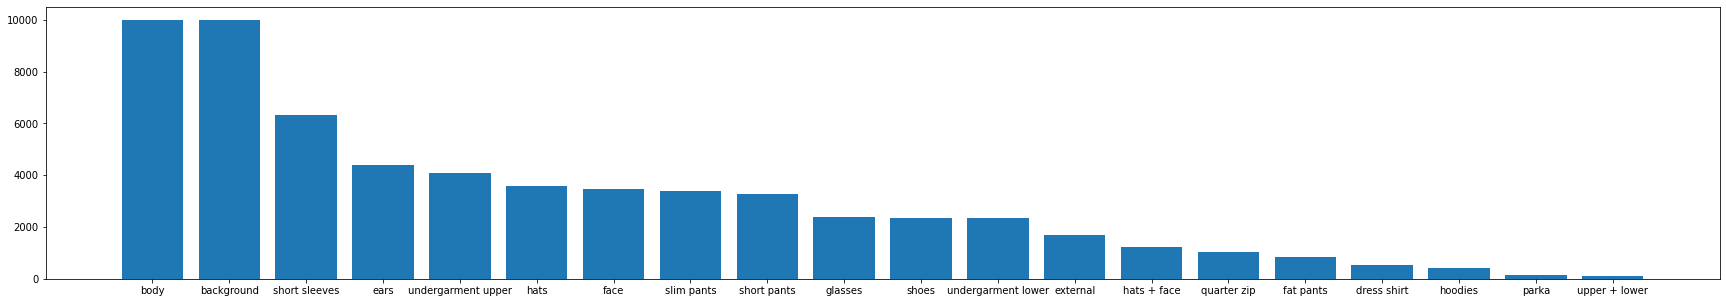

In [194]:
df = pd.DataFrame(values, columns=["filename", "picked_images"])
df['picked_images'] = df['picked_images'].str.split(',')

all_traits = df['picked_images'].apply(convert_filepaths_to_base_traits)

trait_counts = {}
for traits in all_traits:
    topmost_traits = list(set(traits))
    for trait in topmost_traits:
        if trait not in trait_counts:
            trait_counts[trait] = 0
        trait_counts[trait] += 1

trait_counts_list = trait_counts.items()
trait_counts_list = sorted(trait_counts_list, key=lambda item: item[1], reverse=True)
print(len(trait_counts_list))
print(trait_counts_list)
x, y = zip(*trait_counts_list) 

plt.figure(figsize=(30, 5))  # width:20, height:3
plt.bar(x, y)
plt.show()

## Testing Rarity

20
[('body', 1000), ('background', 1000), ('short sleeves', 631), ('ears', 432), ('undergarment upper', 412), ('hats', 351), ('short pants', 338), ('face', 329), ('slim pants', 322), ('glasses', 245), ('shoes', 235), ('undergarment lower', 229), ('external', 183), ('hats + face', 135), ('quarter zip', 96), ('fat pants', 93), ('dress shirt', 56), ('hoodies', 38), ('parka', 12), ('upper + lower', 10)]


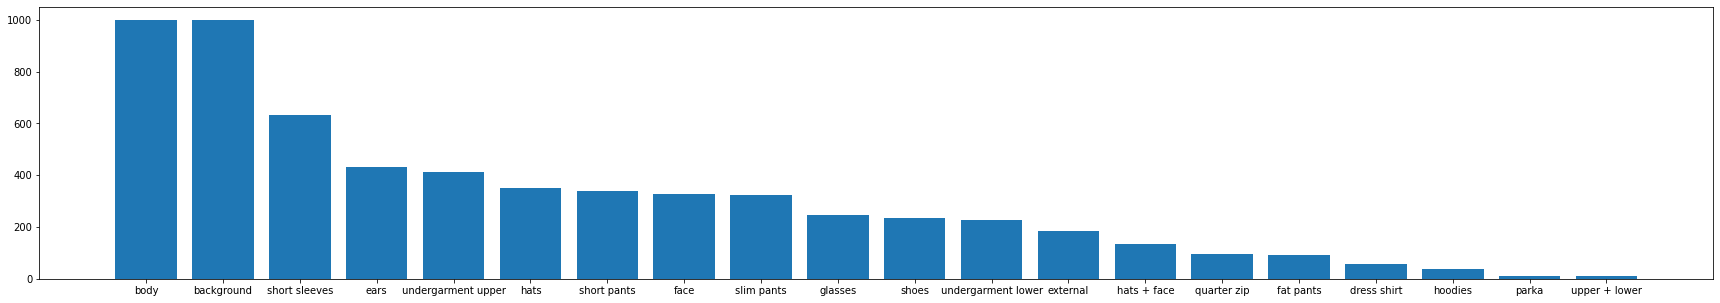

In [174]:
trait_counts = {}
for i in range(1000):        
    picked_trait_images = generate_baby_traits(ordered_traits.copy(), traits_base_filepath, babies_base_filepath)
    base_traits = convert_filepaths_to_base_traits(picked_trait_images)
    
    base_traits = list(set(base_traits))
    
    for trait in base_traits:
        if trait not in trait_counts:
            trait_counts[trait] = 0
        trait_counts[trait] += 1
        
trait_counts_list = trait_counts.items()
trait_counts_list = sorted(trait_counts_list, key=lambda item: item[1], reverse=True)
print(len(trait_counts_list))
print(trait_counts_list)
x, y = zip(*trait_counts_list) 

plt.figure(figsize=(30, 5))  # width:20, height:3
plt.bar(x, y)
plt.show()

20
[('body', 1000), ('background', 1000), ('short sleeves', 641), ('ears', 436), ('undergarment upper', 397), ('hats', 357), ('face', 346), ('short pants', 331), ('slim pants', 330), ('glasses', 246), ('shoes', 231), ('undergarment lower', 227), ('external', 171), ('hats + face', 144), ('quarter zip', 104), ('fat pants', 93), ('hoodies', 50), ('dress shirt', 48), ('upper + lower', 12), ('parka', 8)]


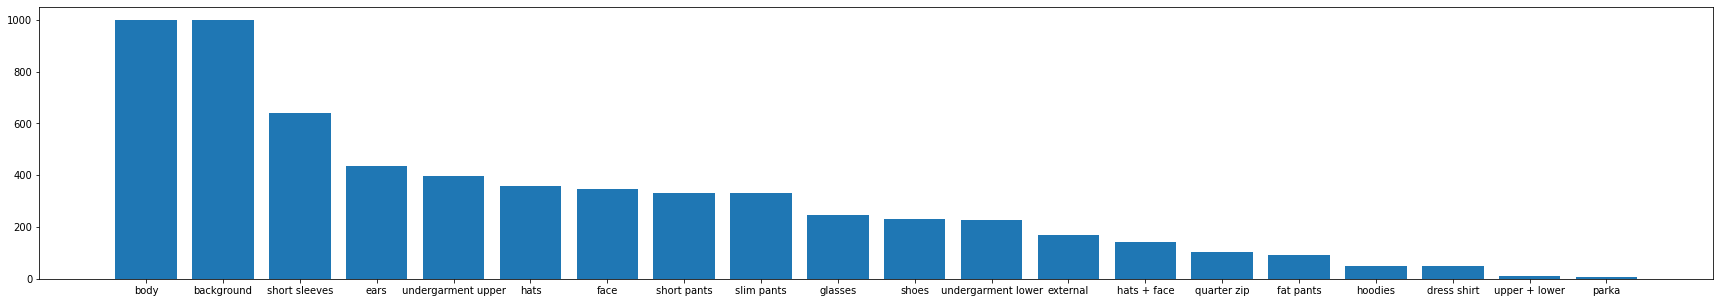

In [175]:
trait_counts = {}
for i in range(1000):        
    picked_trait_images = generate_baby_traits(ordered_traits.copy(), traits_base_filepath, babies_base_filepath)
    base_traits = convert_filepaths_to_base_traits(picked_trait_images)
    
    base_traits = list(set(base_traits))
    
    for trait in base_traits:
        if trait not in trait_counts:
            trait_counts[trait] = 0
        trait_counts[trait] += 1
        
trait_counts_list = trait_counts.items()
trait_counts_list = sorted(trait_counts_list, key=lambda item: item[1], reverse=True)
print(len(trait_counts_list))
print(trait_counts_list)
x, y = zip(*trait_counts_list) 

plt.figure(figsize=(30, 5))  # width:20, height:3
plt.bar(x, y)
plt.show()

In [7]:
from PIL import Image, ImageDraw, ImageChops
import os

x, y = Image.open('Babies/IMG_0578.PNG').size
final_baby_image = Image.new('RGB', (x, y), (192,192,192))

chosen_image = Image.open('Babies/IMG_0578.PNG')
chosen_image = ImageChops.offset(chosen_image, 90, 0)
final_baby_image.paste(chosen_image, (0, 0), chosen_image)
    
# Crop to increase baby appearance
final_baby_image = final_baby_image.crop((0, 140, final_baby_image.width - 140, final_baby_image.height))
    
final_baby_image.save(os.path.join('Babies/', 'mystery2.PNG'))